In [ ]:
!pip install torchdiffeq

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 100.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 78.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 41.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 905.9 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 86.1 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitl

librarii + date

In [ ]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torchdiffeq import odeint

device = 'cuda' if torch.cuda.is_available() else 'cpu'

#deschidere fisiere cu date satelitare
ds = xr.open_mfdataset('date_satelitare/*.nc', combine = 'by_coords')
ice_thickness = ds['sea_ice_thickness']
mean_thickness = ice_thickness.mean(dim = ['yc', 'xc'], skipna=True)
mean_thickness_np = mean_thickness.compute().values
time = ds['time'].values
print(ds)

<xarray.Dataset> Size: 190MB
Dimensions:                 (time: 100, yc: 432, xc: 432, nv: 2)
Coordinates:
    lat                     (yc, xc) float64 1MB dask.array<chunksize=(432, 432), meta=np.ndarray>
    lon                     (yc, xc) float64 1MB dask.array<chunksize=(432, 432), meta=np.ndarray>
  * time                    (time) datetime64[ns] 800B 2010-11-01 ... 2024-12-01
  * xc                      (xc) float64 3kB -5.388e+03 -5.362e+03 ... 5.388e+03
  * yc                      (yc) float64 3kB 5.388e+03 5.362e+03 ... -5.388e+03
Dimensions without coordinates: nv
Data variables:
    quality_flag            (time, yc, xc) int8 19MB dask.array<chunksize=(1, 432, 432), meta=np.ndarray>
    sea_ice_thickness       (time, yc, xc) float32 75MB dask.array<chunksize=(1, 432, 432), meta=np.ndarray>
    status_flag             (time, yc, xc) int8 19MB dask.array<chunksize=(1, 432, 432), meta=np.ndarray>
    uncertainty             (time, yc, xc) float32 75MB dask.array<chunksize=(1, 

impartire date

In [ ]:
#transformare in dataframe
df = pd.DataFrame({
    'time': pd.to_datetime(time),
    'ice_thickness': mean_thickness_np
})

#adaugare coloane pt an, luna, denumire luna
df['year'] = df['time'].dt.year
df['month'] = df['time'].dt.month
df['month_name'] = df['time'].dt.strftime('%b')

#impartire pe ani
def compute_season_year(row):
  if row['month'] >= 10: #oct, nov, dec
    return row['year'] + 1
  else: #ian - apr
    return row['year']

df['season_year'] = df.apply(compute_season_year, axis=1)

df = df[df['month'].isin([10, 11, 12, 1, 2, 3, 4])].reset_index(drop=True)

#impartire pe train/test
df_train = df[df['season_year'].between(2011, 2022)].reset_index(drop=True)
df_test = df[df['season_year'] >= 2023].reset_index(drop=True)

#salvare csv
df_train.to_csv('train.csv', index=False)
df_test.to_csv('test.csv', index=False)

print(f'dim train: {df_train.shape}, dim test: {df_test.shape}')

dim train: (83, 6), dim test: (17, 6)


citire date

In [ ]:
train_df = pd.read_csv('train.csv')
x_train_np = train_df['ice_thickness'].values

test_df = pd.read_csv('test.csv')
x_test_np = test_df['ice_thickness'].values

print('date de antrenament:', x_train_np.shape)
print('date de test:', x_test_np.shape)

date de antrenament: (83,)
date de test: (17,)


normalizare - pregatire date pt neural ode

In [ ]:
#media si deviatia standard
mean_train = train_df['ice_thickness'].mean()
std_train = train_df['ice_thickness'].std()
print(f"Media globală train: {mean_train}, Deviația standard globală: {std_train}")

#normalizare globala la train
x_train_np = train_df['ice_thickness'].values
x_train_norm = (x_train_np - mean_train) / std_train
x_train_tensor = torch.tensor(x_train_norm, dtype=torch.float32, device=device).unsqueeze(-1)
print(f'Normalizare globală train completă: {x_train_tensor.shape}')

#normalizare globala la test
x_test_np = test_df['ice_thickness'].values
x_test_norm = (x_test_np - mean_train) / std_train
x_test_tensor = torch.tensor(x_test_norm, dtype=torch.float32, device=device).unsqueeze(-1)
print(f'Normalizare globală test completă: {x_test_tensor.shape}')


Media globală train: 1.2706124220481925, Deviația standard globală: 0.21656114900919649
Normalizare globală train completă: torch.Size([83, 1])
Normalizare globală test completă: torch.Size([17, 1])


definire neural ode

In [ ]:
class ODEFunc(nn.Module):
  def __init__(self, hidden_dim=512):
    super().__init__()
    self.net = nn.Sequential(
        nn.Linear(1, hidden_dim),
        nn.ReLU(),
        nn.Linear(hidden_dim, hidden_dim),
        nn.ReLU(),
        nn.Dropout(0.2),
        nn.Linear(hidden_dim, 1)
    )

  def forward(self, t, x):
    return self.net(x)

func = ODEFunc().to(device)

functiile de predictie si loss

In [ ]:
def predict(x0, t, func):
  pred_x = odeint(func, x0, t, method='rk4', rtol=1e-7, atol=1e-10)
  return pred_x

loss_fn = nn.MSELoss()

functie de antrenare pe sezon

In [ ]:
def train_season(x_season, func, n_epochs=1000, lr=1e-2, sezon_id=None):
  x0 = x_season[0]
  t_season = torch.linspace(0, len(x_season)-1, len(x_season)).to(device)
  optimizer = torch.optim.Adam(func.parameters(), lr=lr, weight_decay=1e-3)
  scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=300, gamma=0.5)

  for epoch in range(n_epochs):
    optimizer.zero_grad()
    pred_x = predict(x0, t_season, func)
    loss = loss_fn(pred_x, x_season)
    loss.backward()
    torch.nn.utils.clip_grad_norm_(func.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()

    if epoch == 1 or epoch % 100 == 0:
      print(f'epoca {epoch}: Loss = {loss.item():6f}')

      real_train = x_season.detach().cpu().numpy()
      pred_train = pred_x.detach().cpu().numpy()

      plt.figure(figsize=(8,4))
      plt.plot(range(len(x_season)), real_train, label='Real', color='blue', marker='o')
      plt.plot(range(len(x_season)), pred_train, label='Predicție', color='green', linestyle='--', marker='x')
      plt.xlabel('Index lună în sezon')
      plt.ylabel('Grosimea normalizată')
      plt.title(f'Sezon {sezon_id}, Epoca {epoch}')
      plt.legend()
      plt.grid(True)
      plt.tight_layout()
      plt.show()

antrenare

--- antrenare sezon 2011 ---
epoca 0: Loss = 0.014877


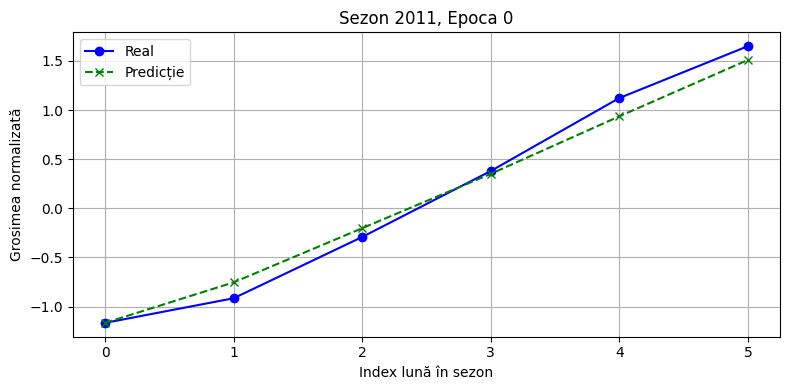

epoca 1: Loss = 0.035871


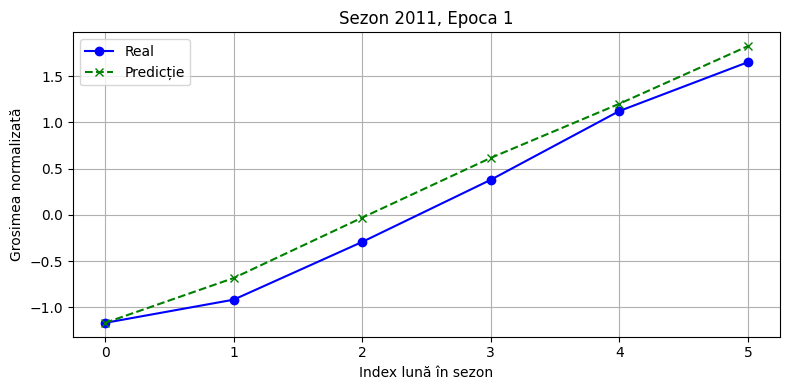

epoca 100: Loss = 0.002098


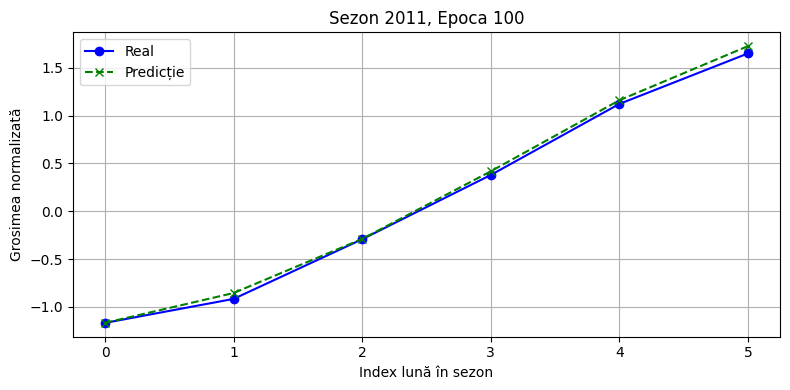

epoca 200: Loss = 0.002656


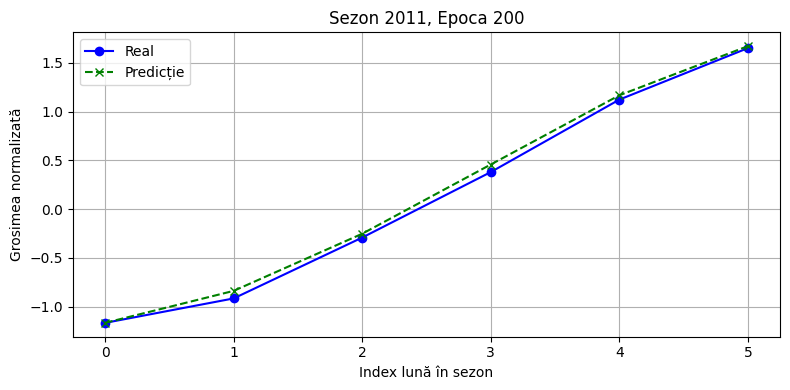

epoca 300: Loss = 0.005623


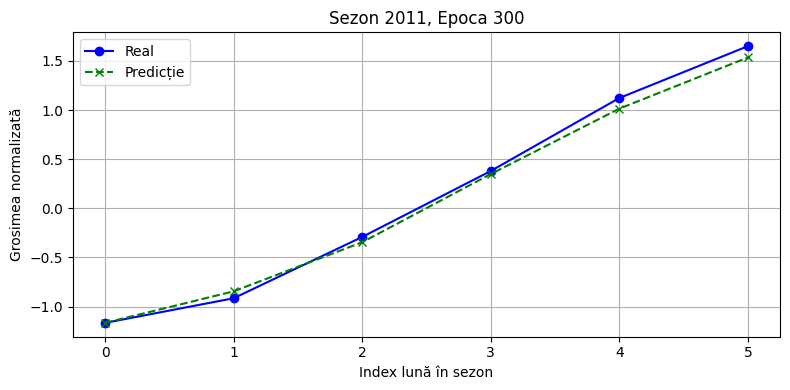

epoca 400: Loss = 0.005226


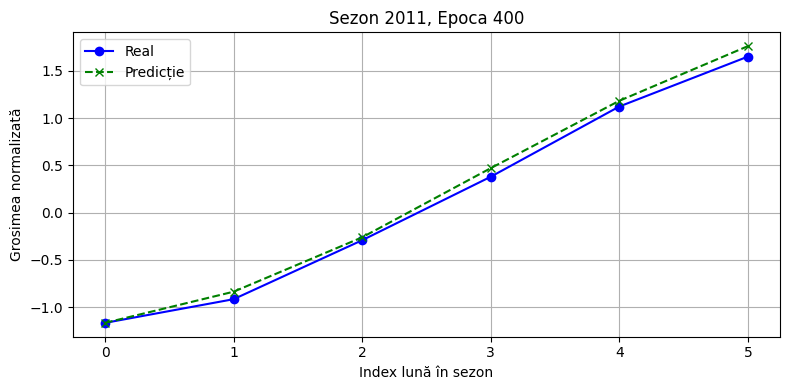

epoca 500: Loss = 0.001199


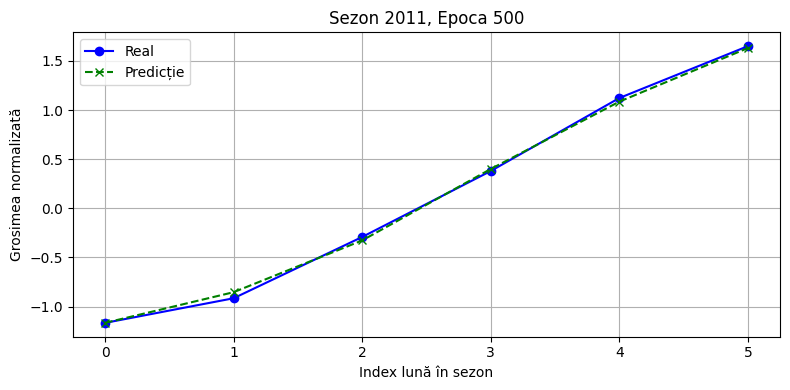

epoca 600: Loss = 0.002189


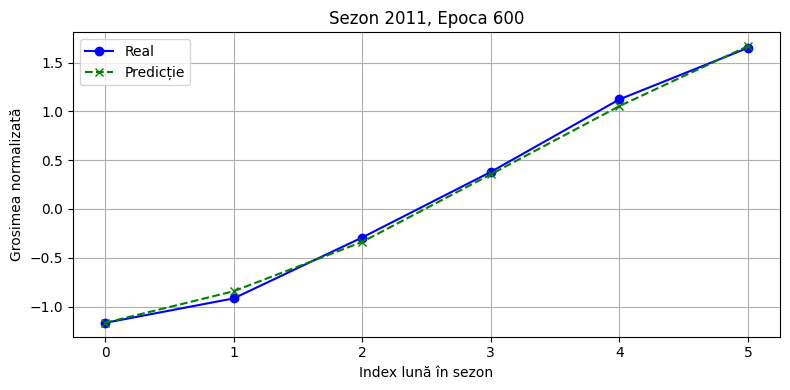

epoca 700: Loss = 0.003008


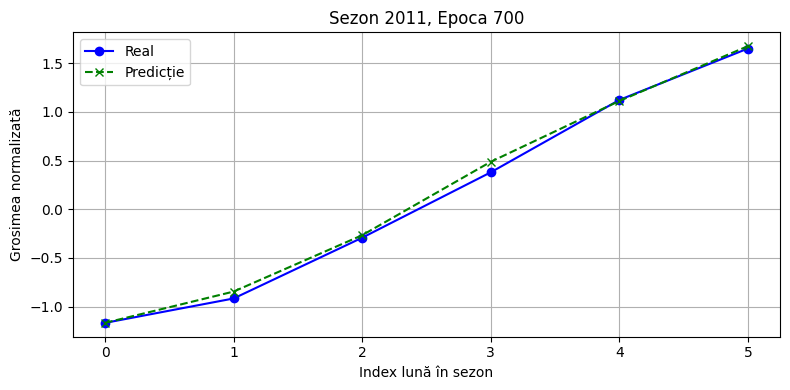

epoca 800: Loss = 0.000934


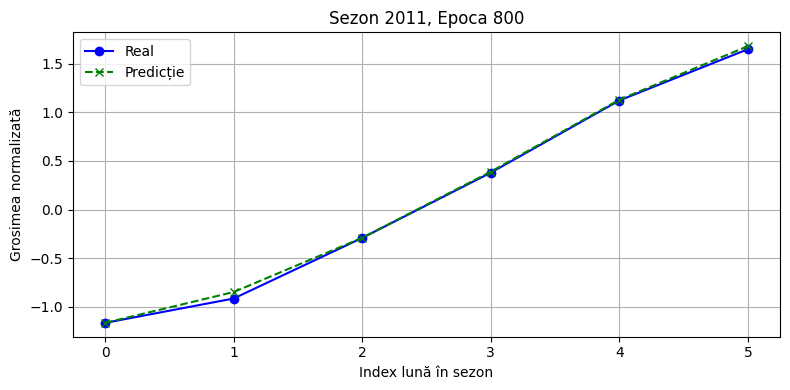

epoca 900: Loss = 0.000927


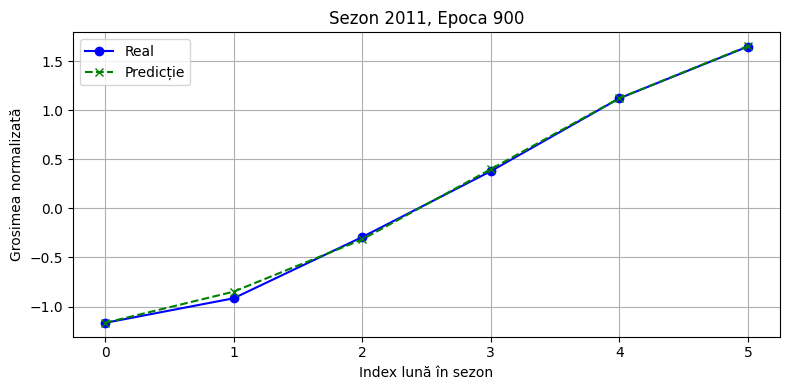

--- antrenare sezon 2012 ---
epoca 0: Loss = 0.078037


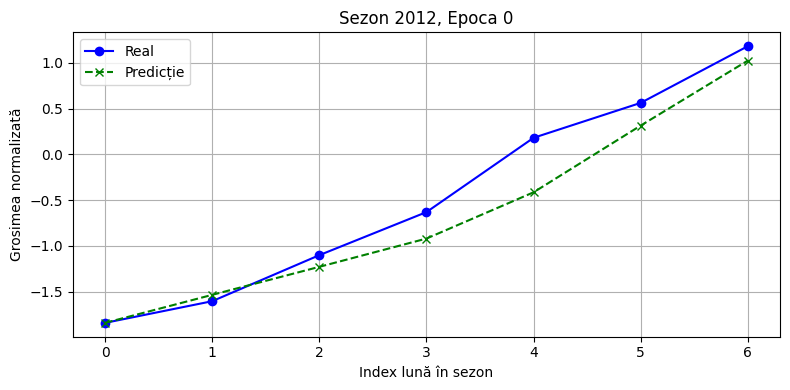

epoca 1: Loss = 0.030360


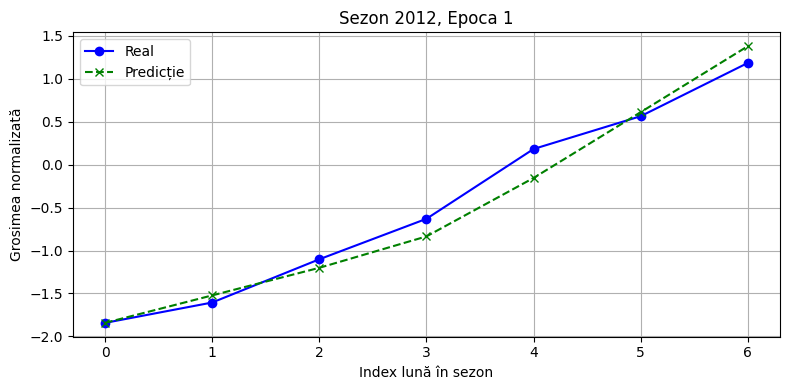

epoca 100: Loss = 0.005082


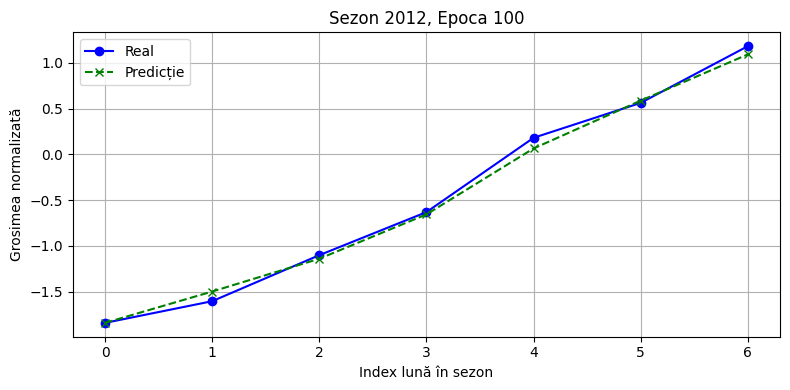

epoca 200: Loss = 0.004652


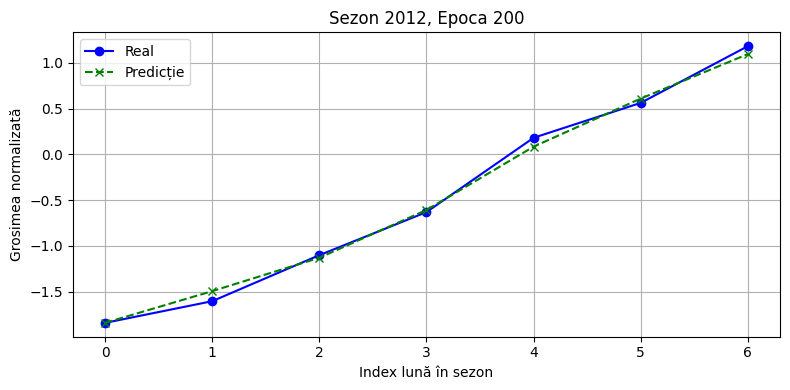

epoca 300: Loss = 0.004556


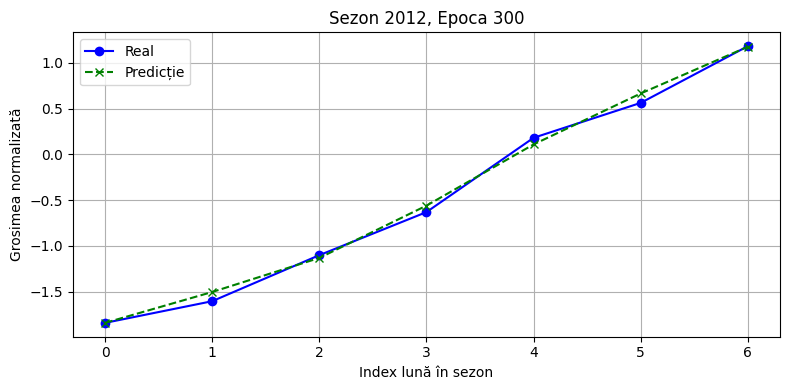

epoca 400: Loss = 0.008141


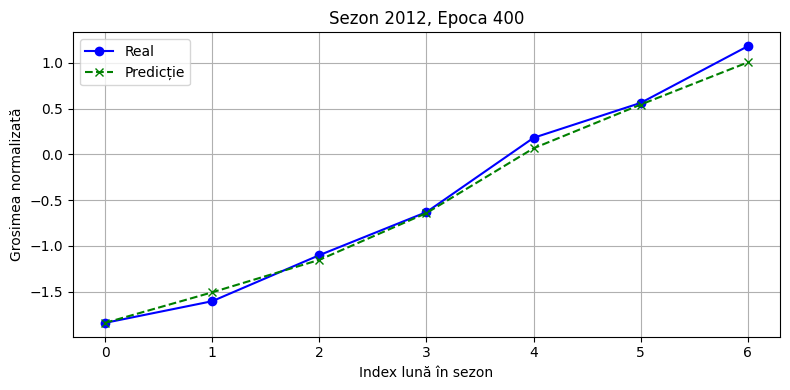

epoca 500: Loss = 0.015471


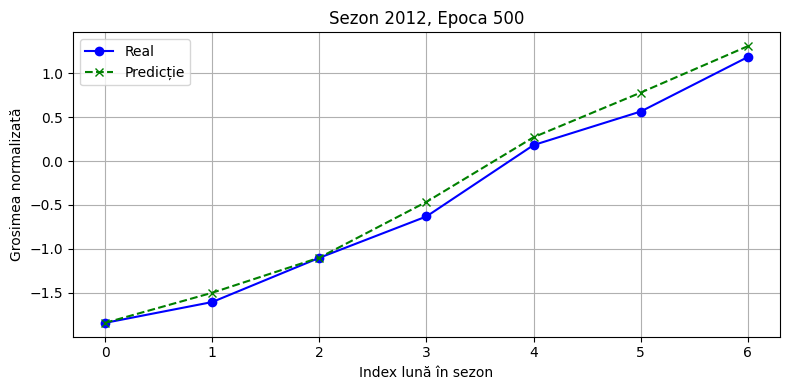

epoca 600: Loss = 0.004421


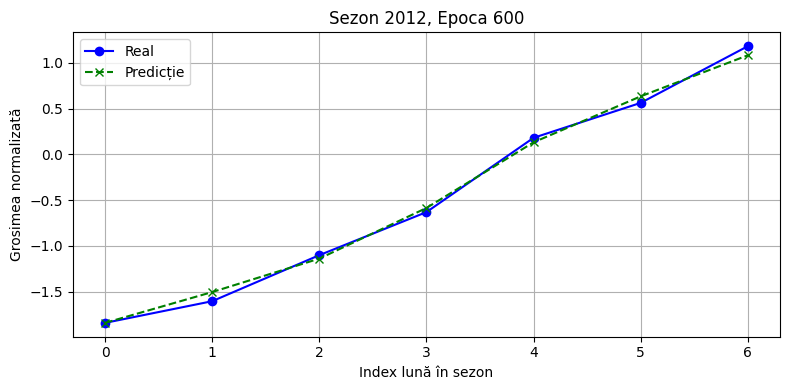

epoca 700: Loss = 0.004844


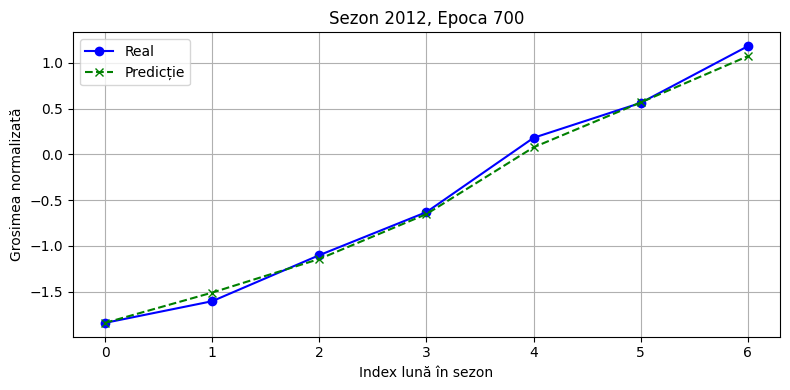

epoca 800: Loss = 0.003253


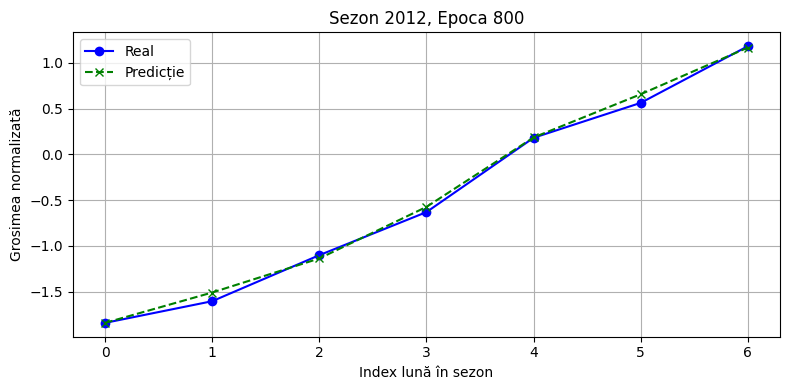

epoca 900: Loss = 0.002723


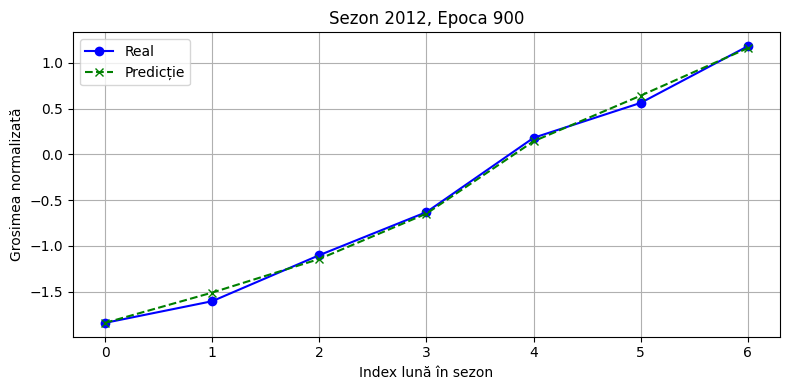

--- antrenare sezon 2013 ---
epoca 0: Loss = 0.602308


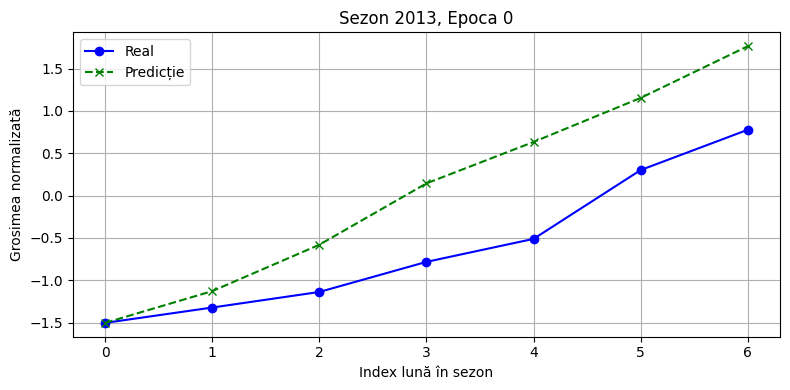

epoca 1: Loss = 0.298519


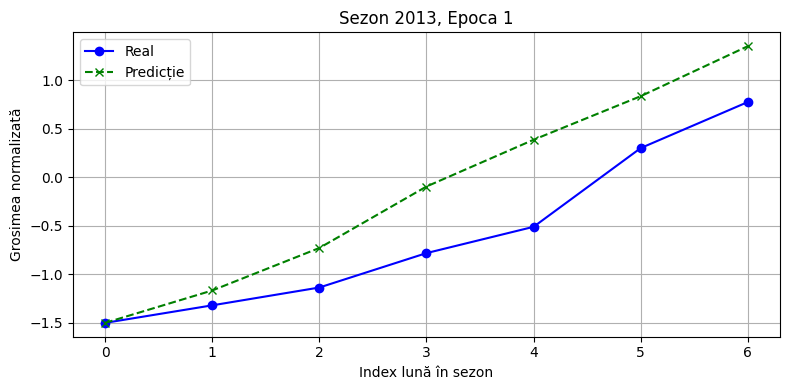

epoca 100: Loss = 0.002367


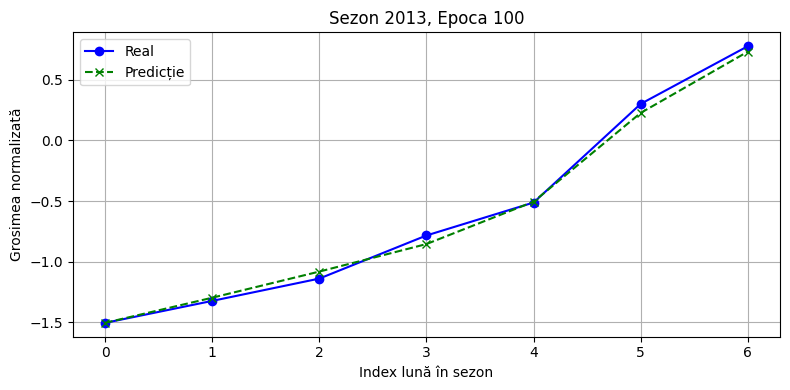

epoca 200: Loss = 0.002194


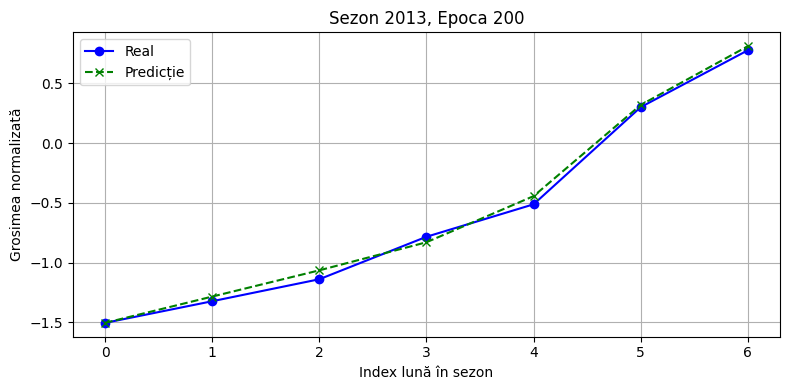

epoca 300: Loss = 0.002070


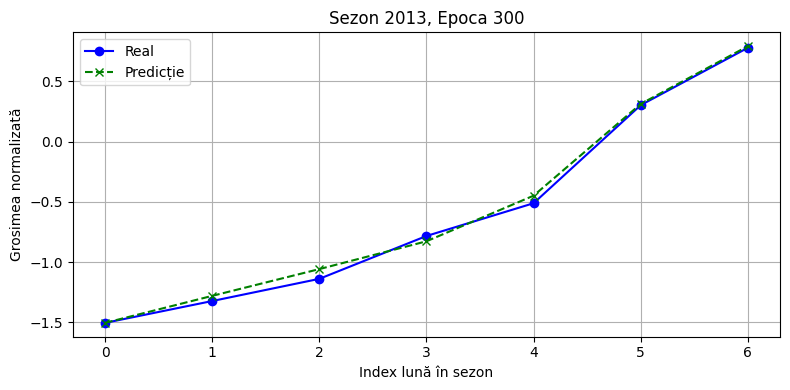

epoca 400: Loss = 0.004249


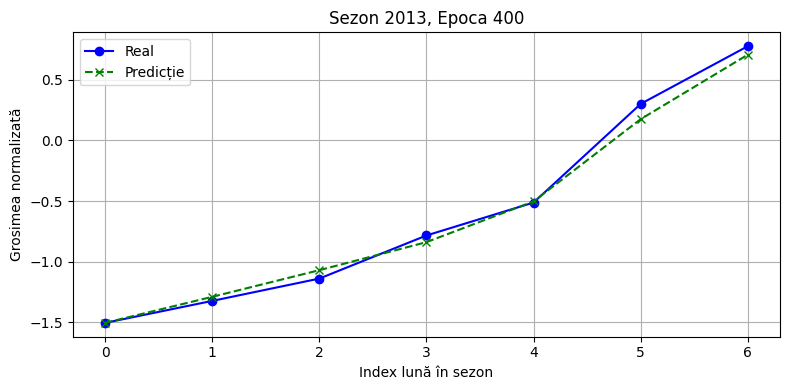

epoca 500: Loss = 0.003644


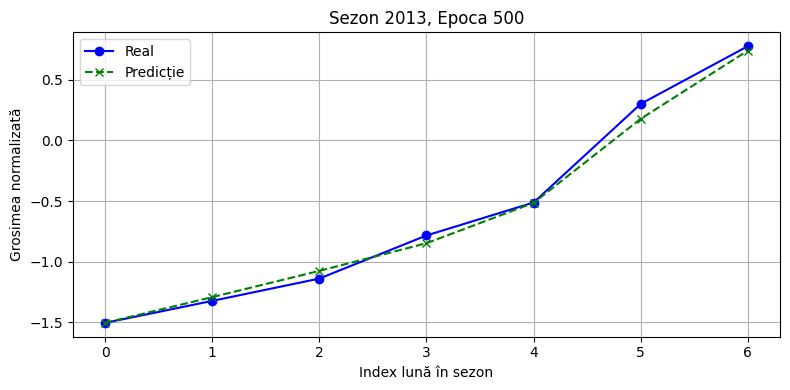

epoca 600: Loss = 0.002522


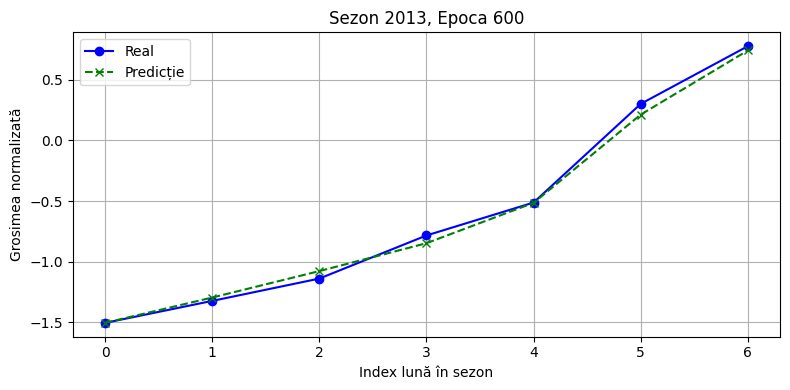

epoca 700: Loss = 0.005969


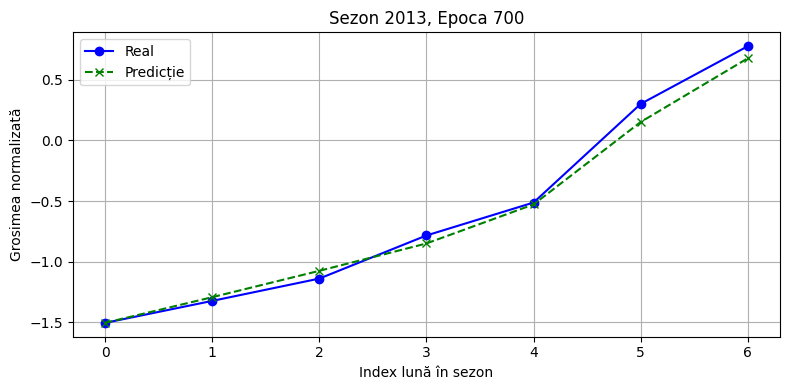

epoca 800: Loss = 0.001465


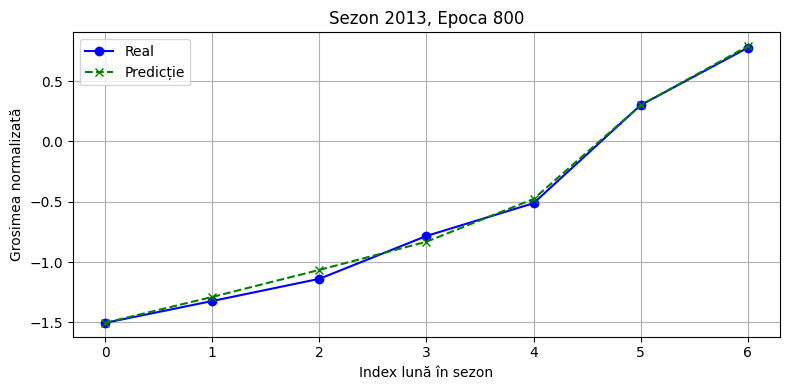

epoca 900: Loss = 0.003804


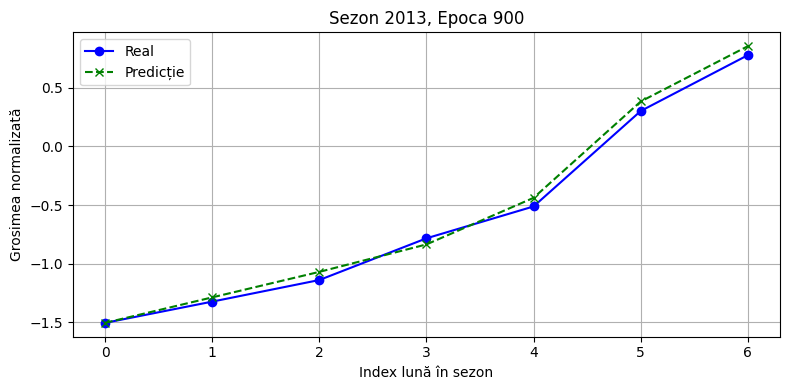

--- antrenare sezon 2014 ---
epoca 0: Loss = 0.351214


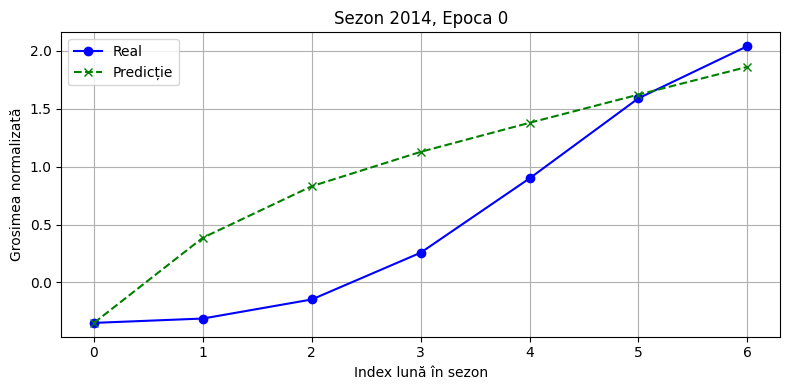

epoca 1: Loss = 0.231694


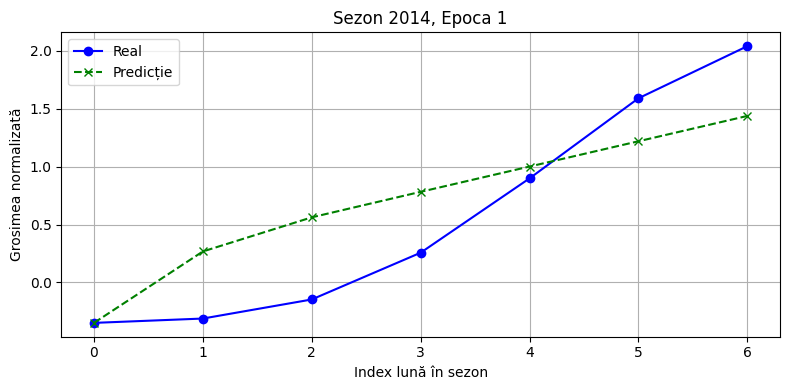

epoca 100: Loss = 0.015769


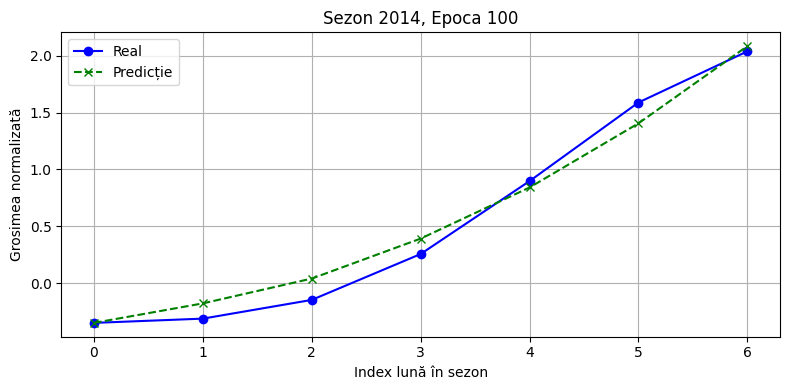

epoca 200: Loss = 0.016771


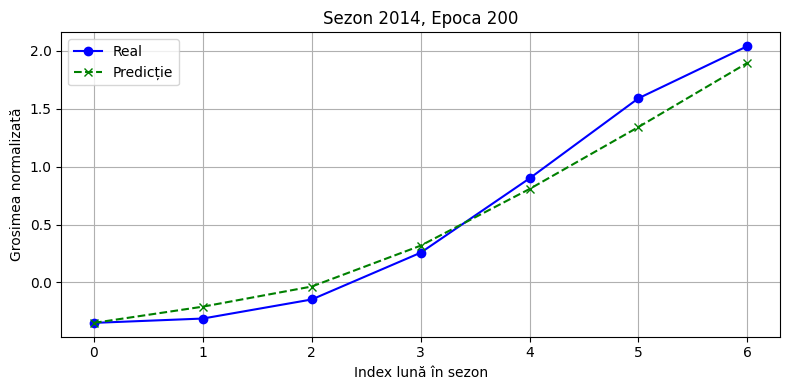

epoca 300: Loss = 0.019740


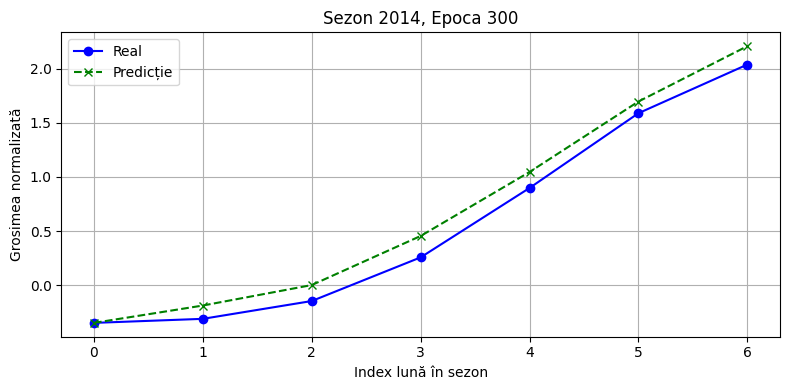

epoca 400: Loss = 0.004216


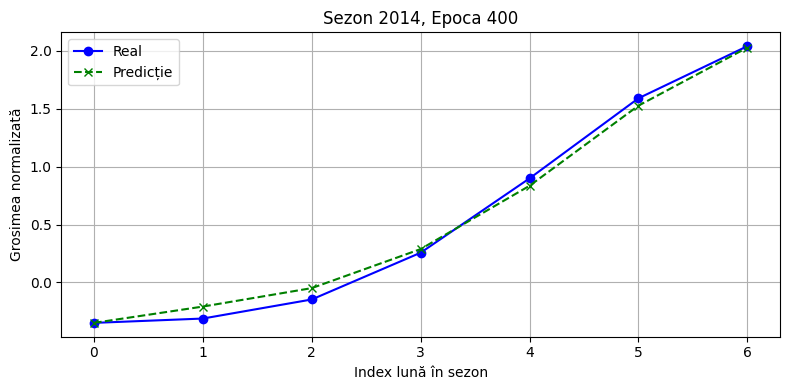

epoca 500: Loss = 0.003652


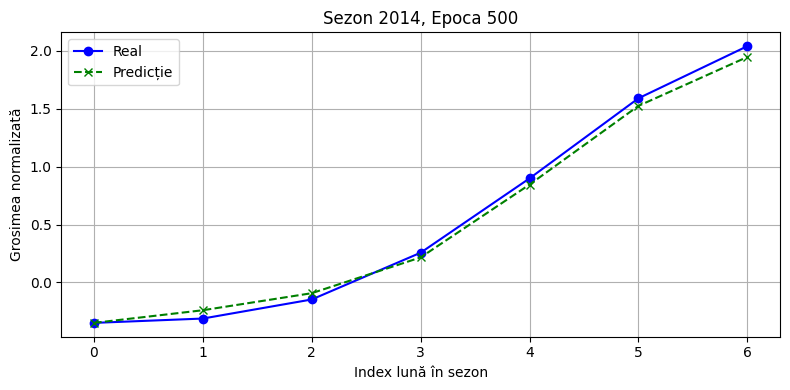

epoca 600: Loss = 0.009537


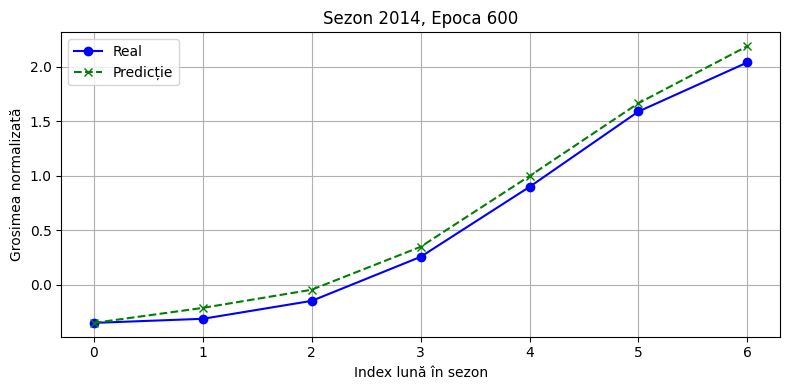

epoca 700: Loss = 0.003915


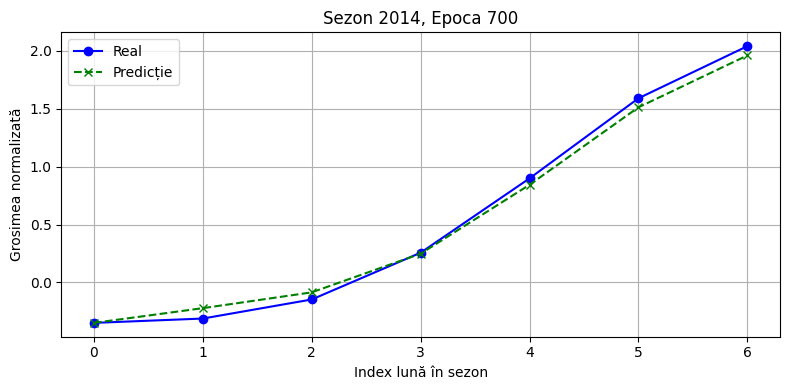

epoca 800: Loss = 0.002256


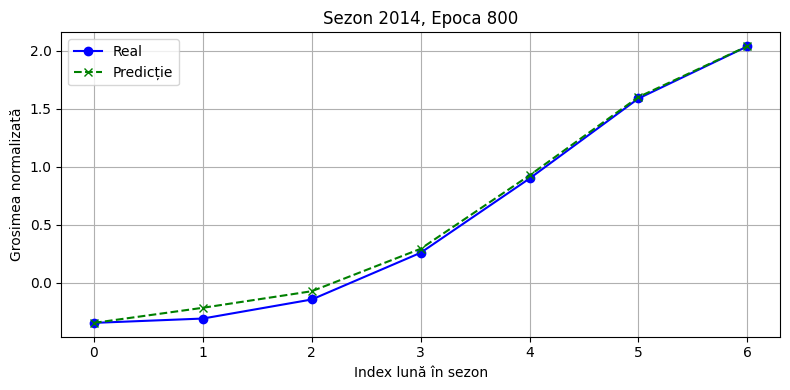

epoca 900: Loss = 0.004570


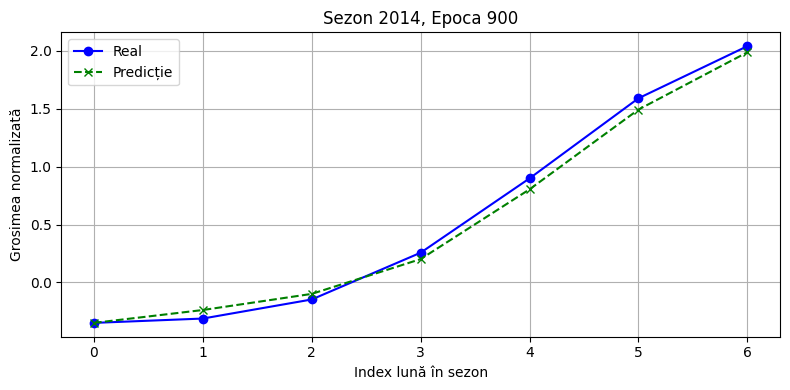

--- antrenare sezon 2015 ---
epoca 0: Loss = 2.324864


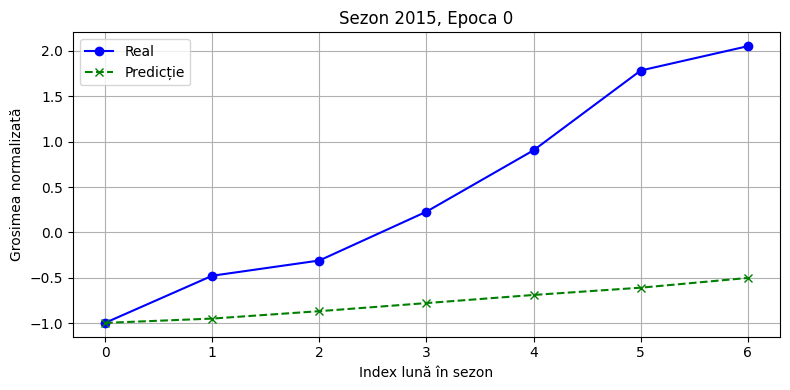

epoca 1: Loss = 1.891051


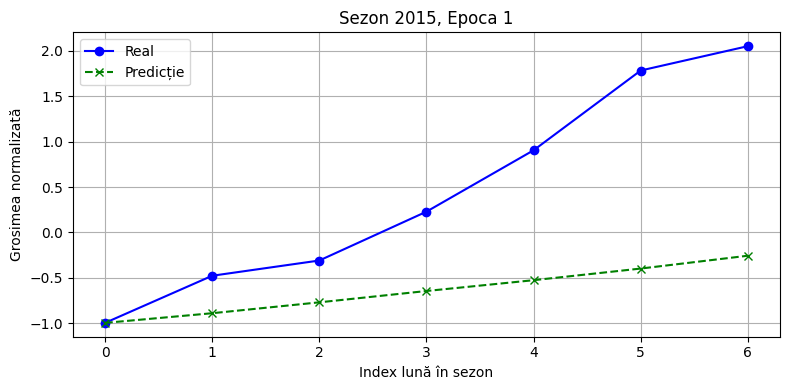

epoca 100: Loss = 0.008238


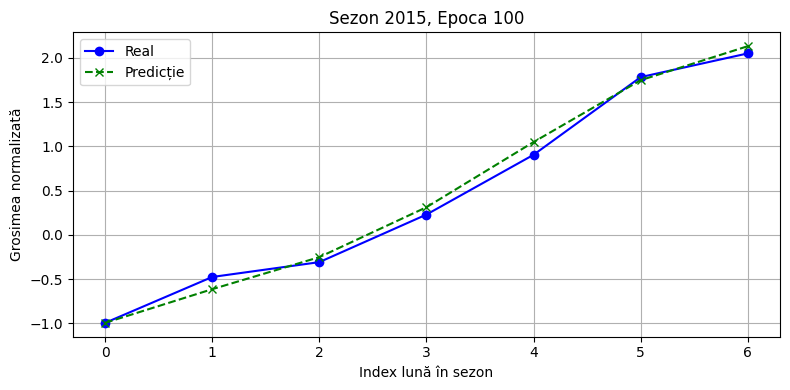

epoca 200: Loss = 0.005227


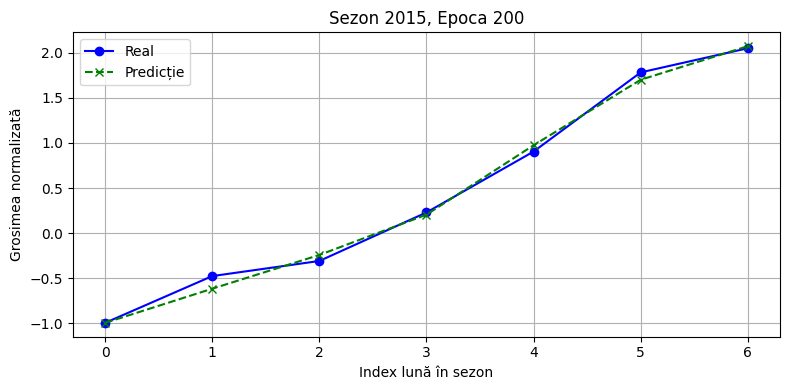

epoca 300: Loss = 0.005538


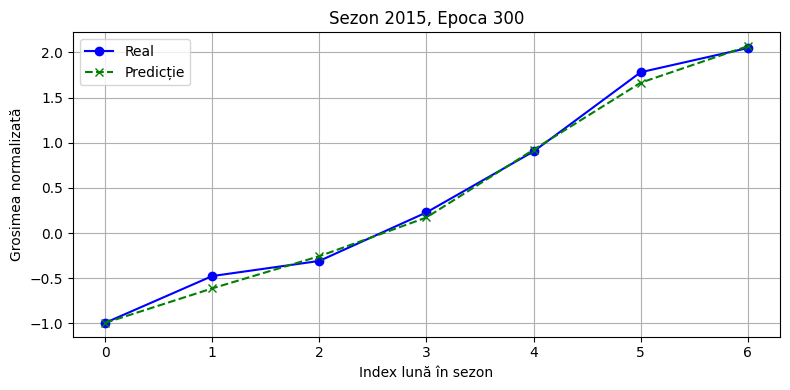

epoca 400: Loss = 0.004257


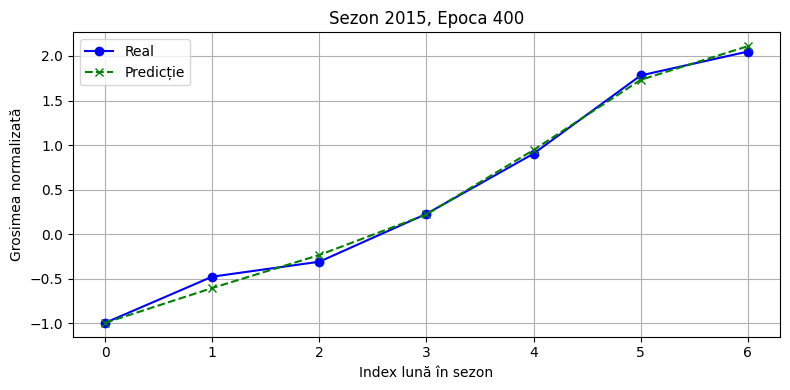

epoca 500: Loss = 0.005127


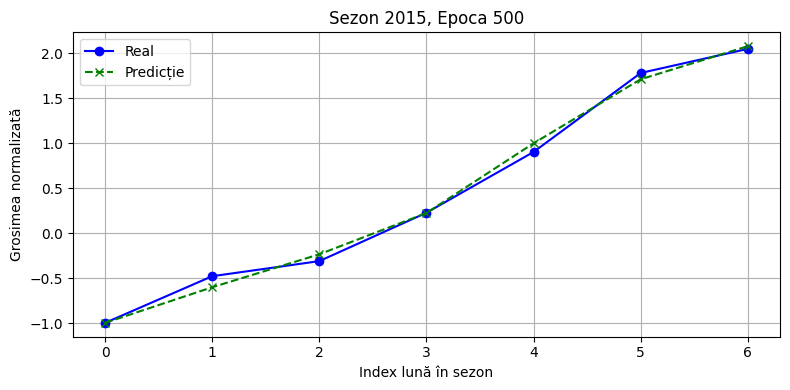

epoca 600: Loss = 0.013063


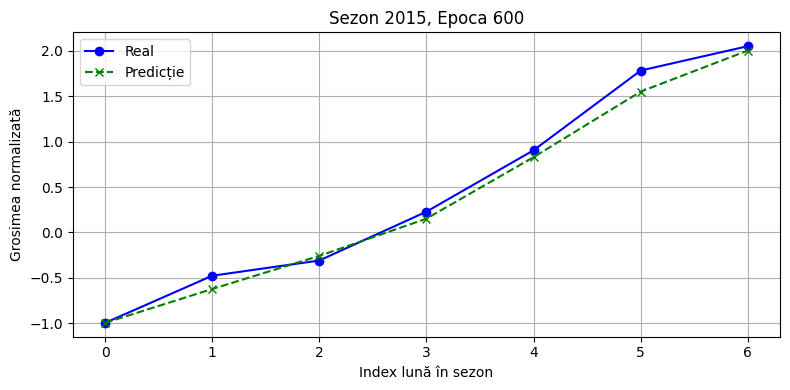

epoca 700: Loss = 0.004340


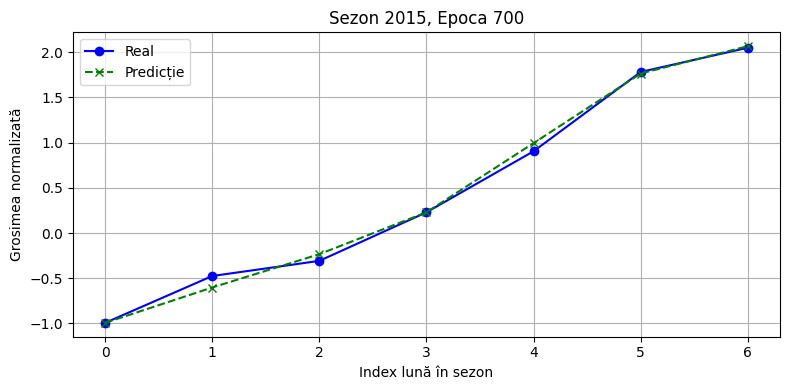

epoca 800: Loss = 0.003866


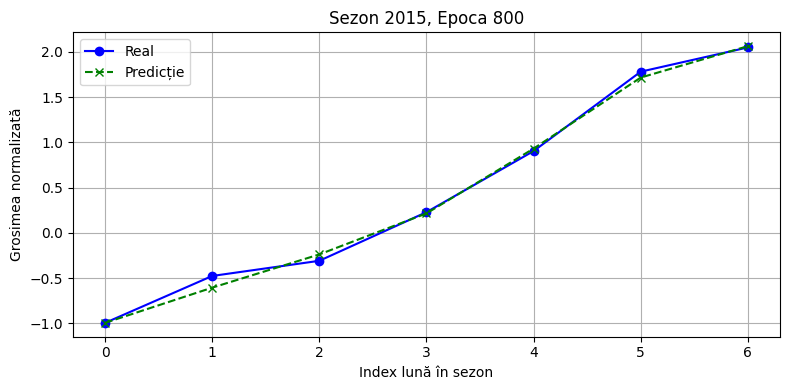

epoca 900: Loss = 0.004562


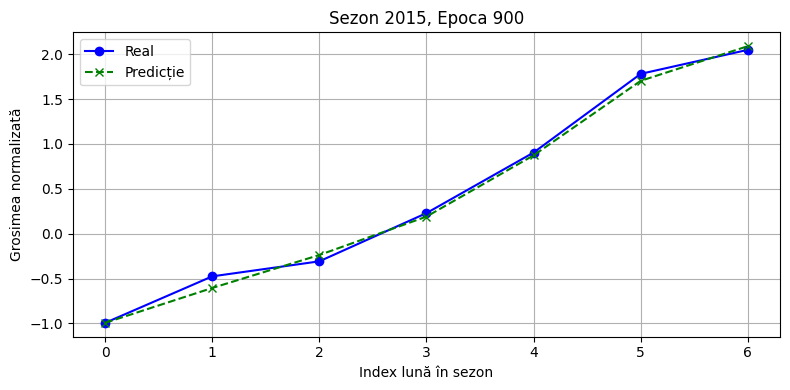

--- antrenare sezon 2016 ---
epoca 0: Loss = 0.039628


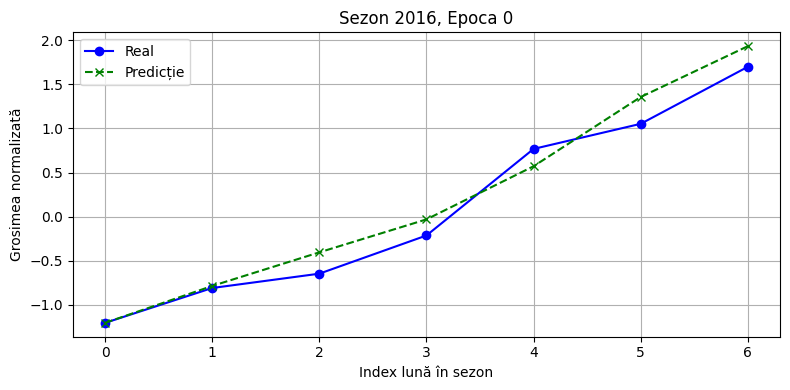

epoca 1: Loss = 0.081359


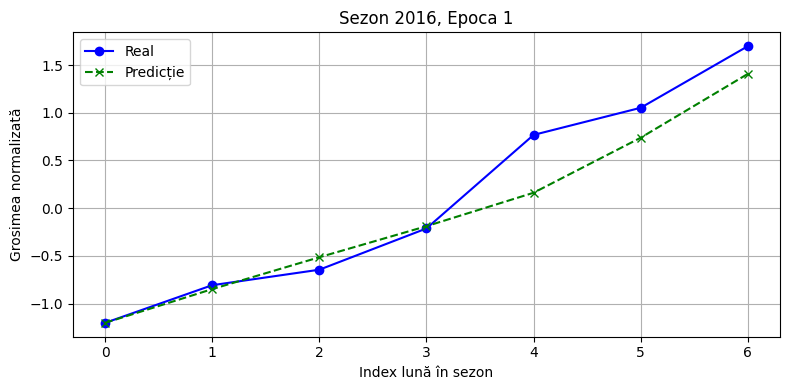

epoca 100: Loss = 0.009225


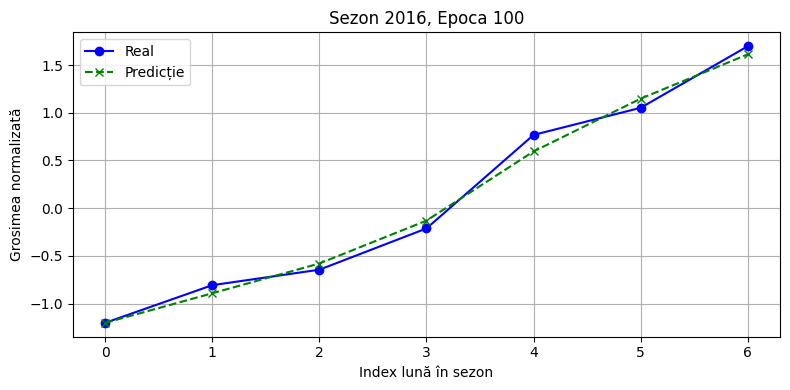

epoca 200: Loss = 0.006639


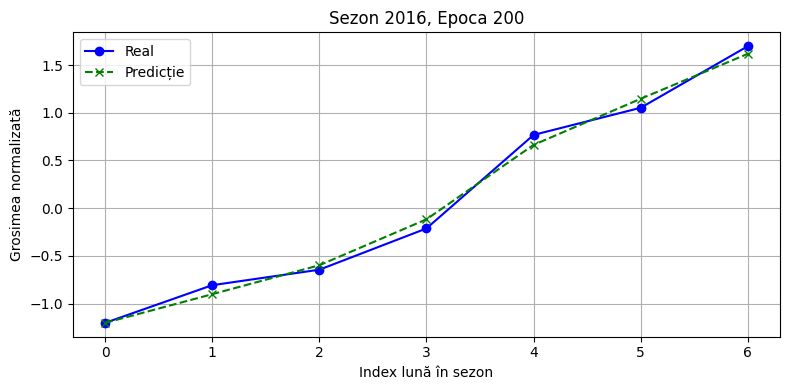

epoca 300: Loss = 0.004483


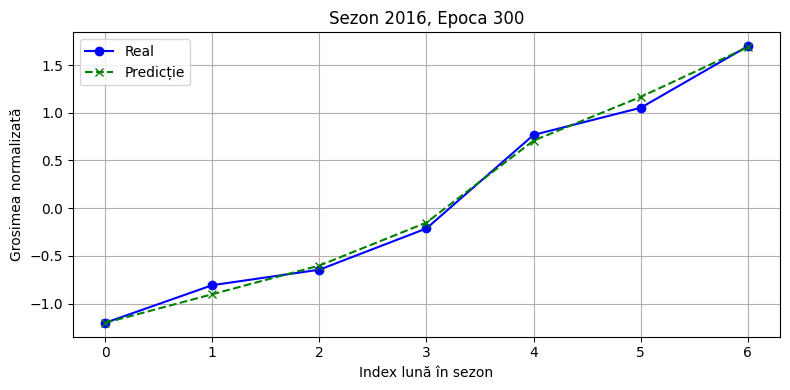

epoca 400: Loss = 0.004644


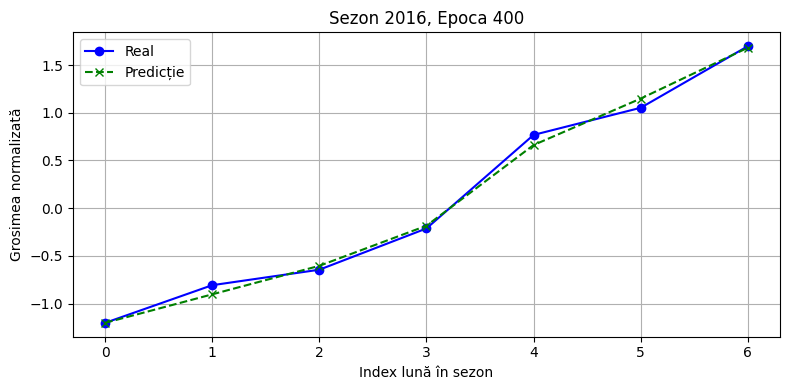

epoca 500: Loss = 0.005463


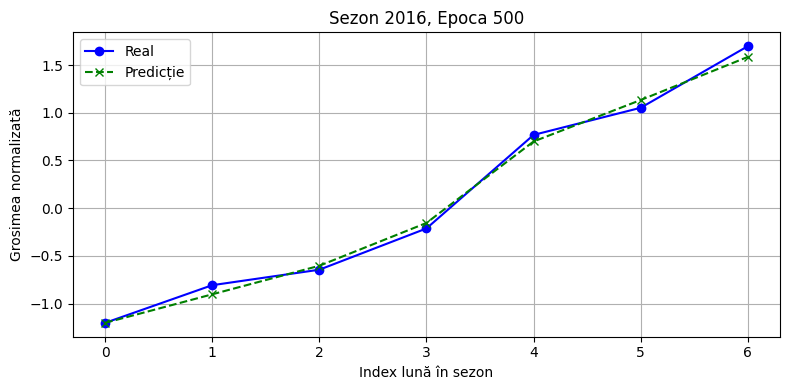

epoca 600: Loss = 0.004449


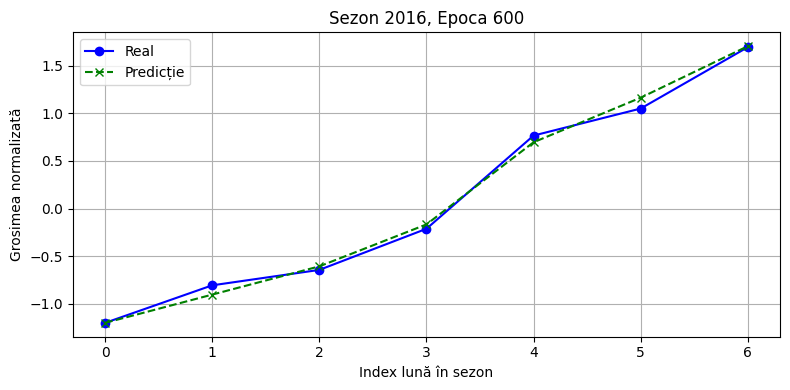

epoca 700: Loss = 0.003718


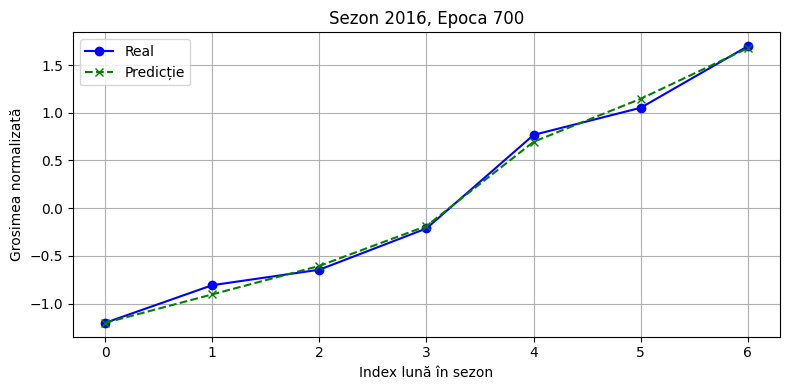

epoca 800: Loss = 0.004736


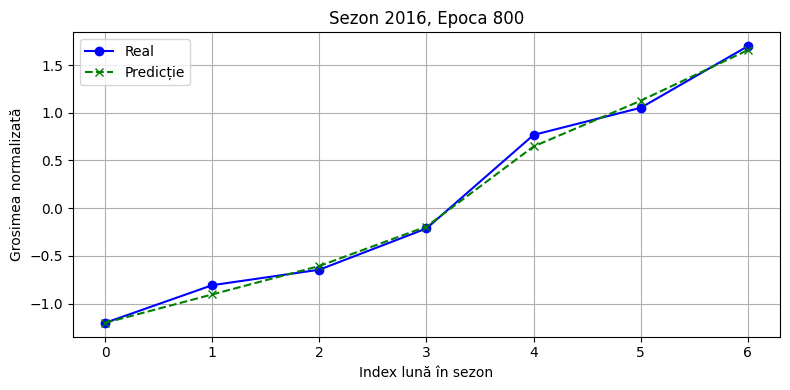

epoca 900: Loss = 0.005479


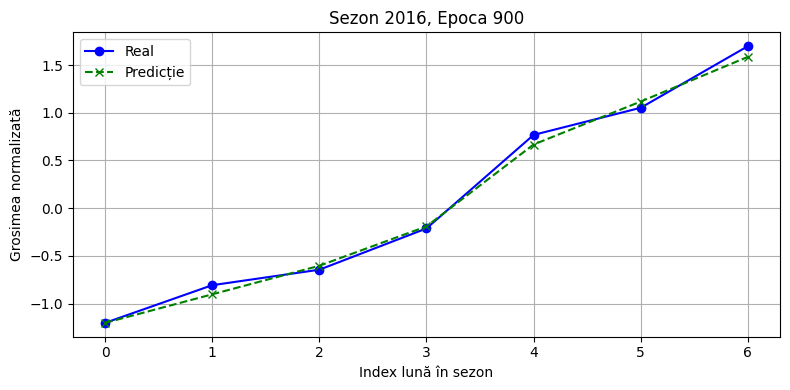

--- antrenare sezon 2017 ---
epoca 0: Loss = 1.045966


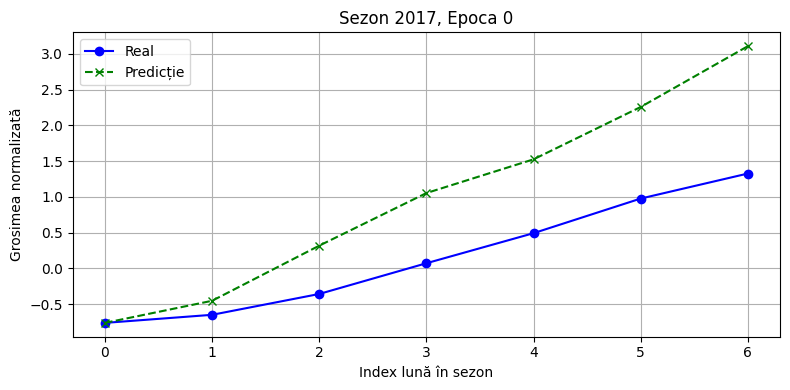

epoca 1: Loss = 0.213530


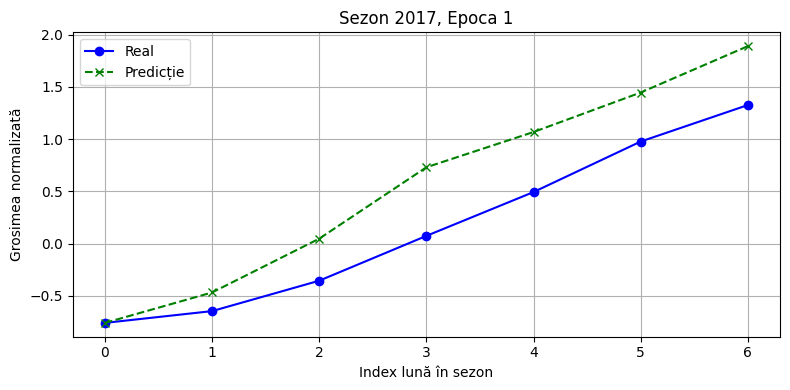

epoca 100: Loss = 0.006576


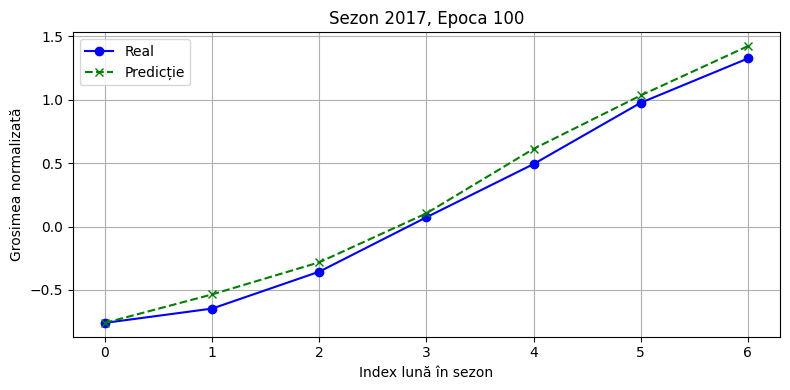

epoca 200: Loss = 0.002189


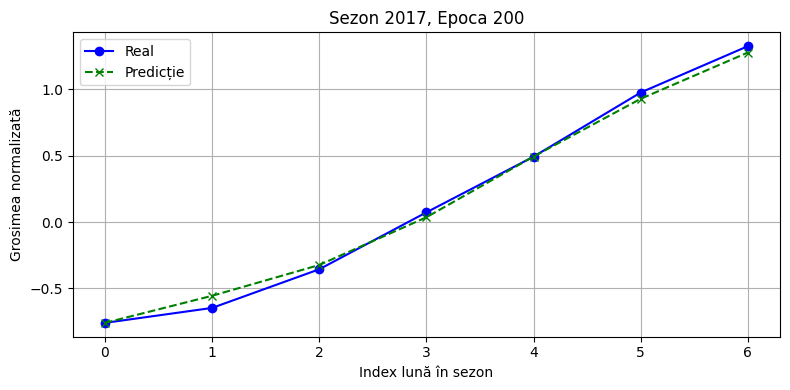

epoca 300: Loss = 0.001438


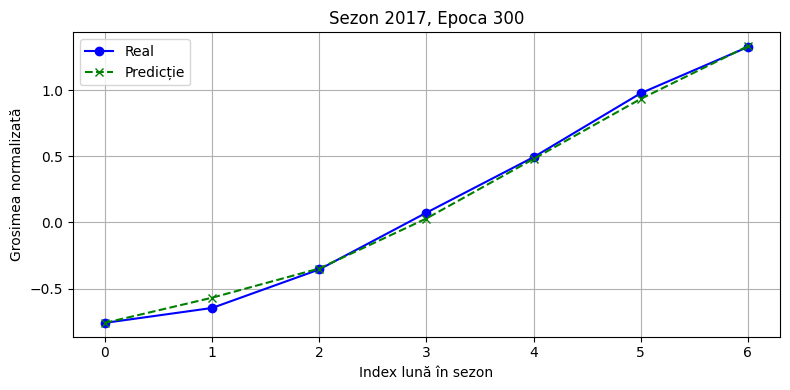

epoca 400: Loss = 0.003314


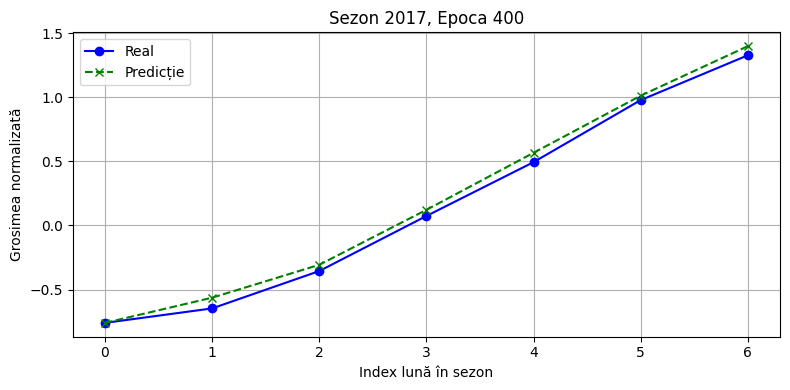

epoca 500: Loss = 0.002056


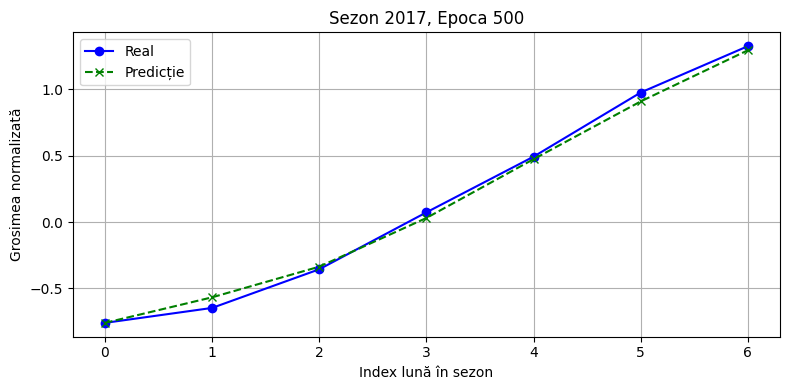

epoca 600: Loss = 0.002597


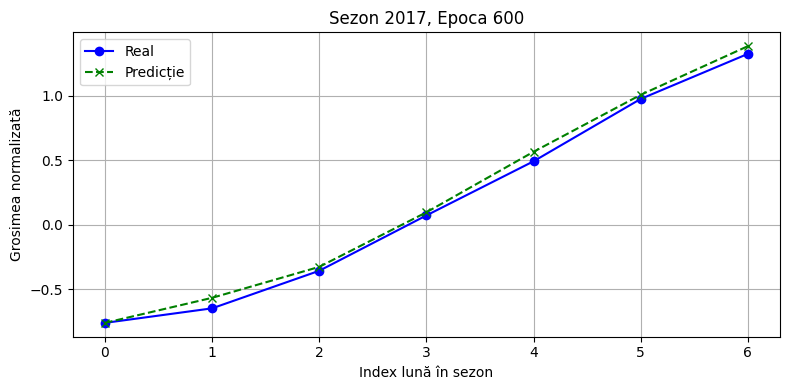

epoca 700: Loss = 0.003376


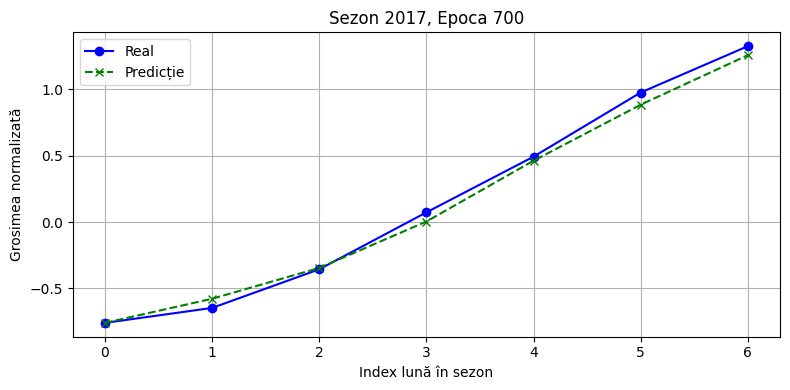

epoca 800: Loss = 0.000917


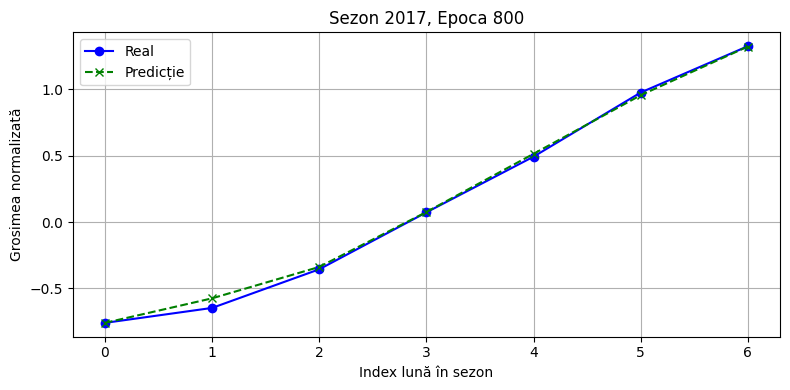

epoca 900: Loss = 0.001636


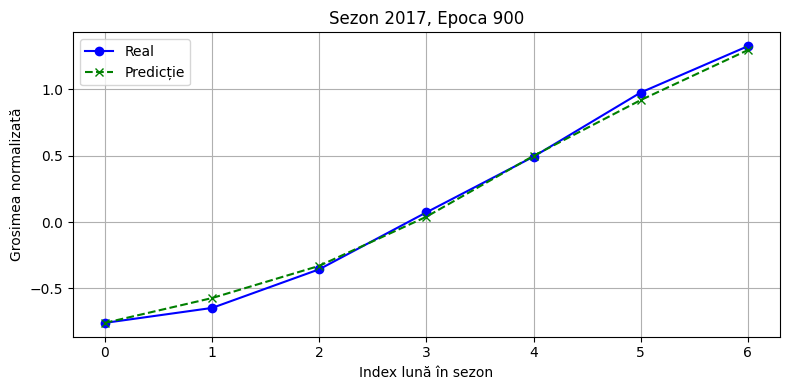

--- antrenare sezon 2018 ---
epoca 0: Loss = 0.008220


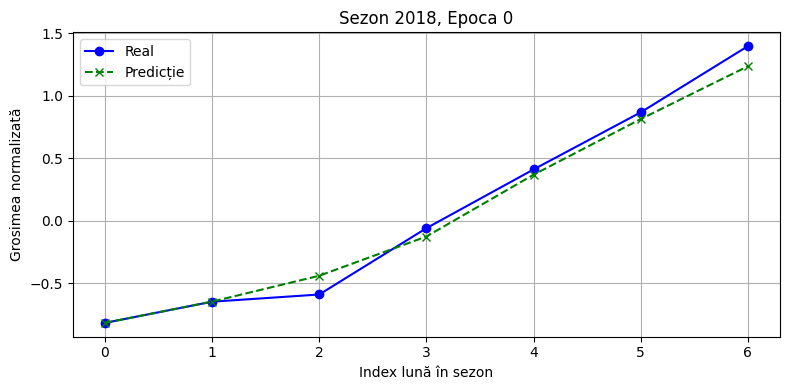

epoca 1: Loss = 0.052486


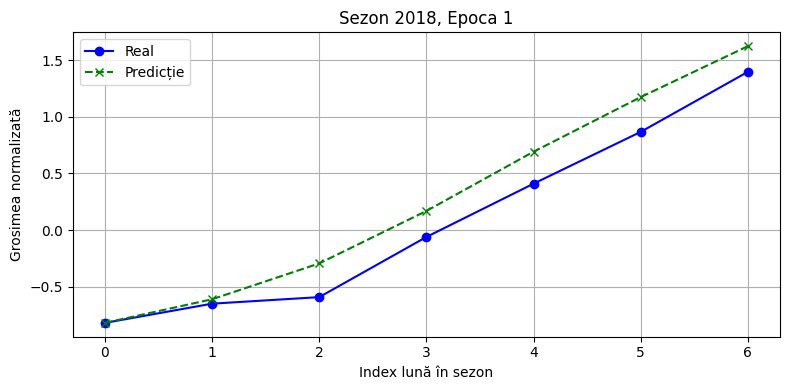

epoca 100: Loss = 0.003119


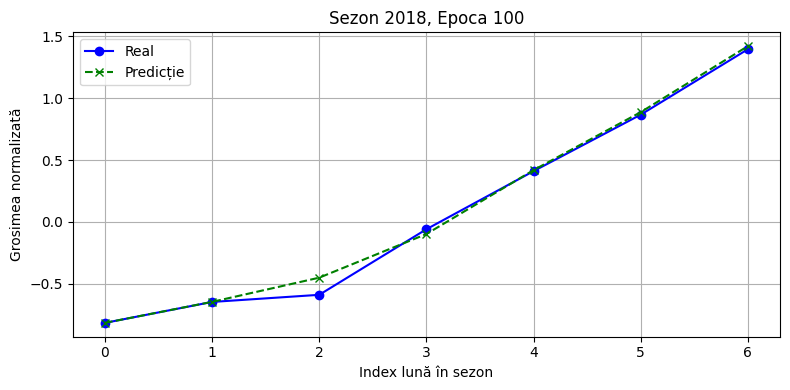

epoca 200: Loss = 0.007016


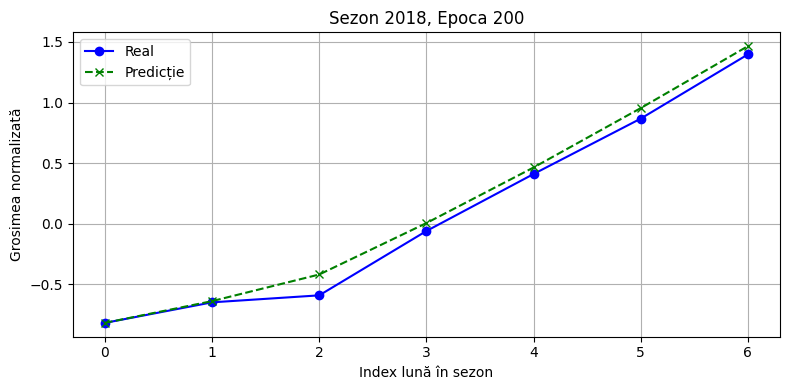

epoca 300: Loss = 0.003097


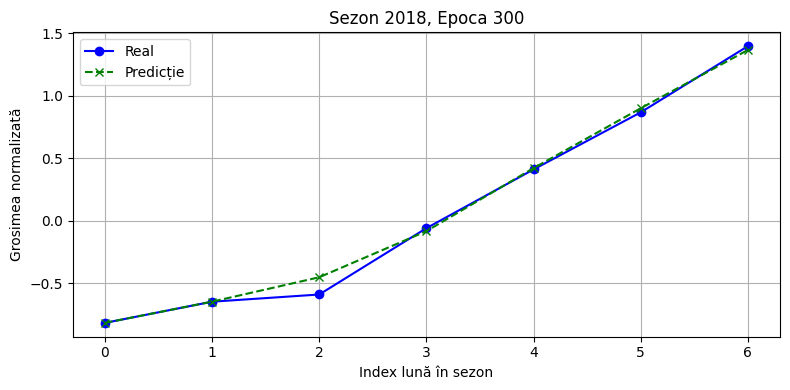

epoca 400: Loss = 0.007309


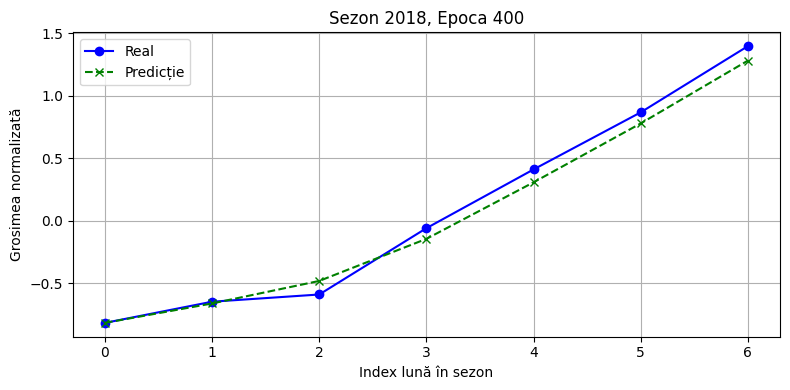

epoca 500: Loss = 0.017418


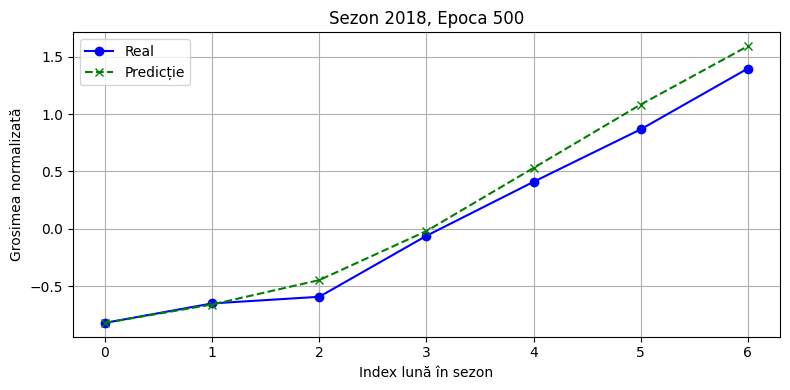

epoca 600: Loss = 0.002736


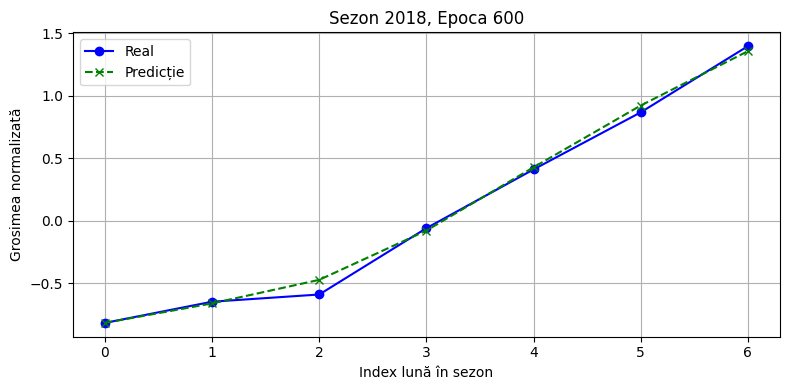

epoca 700: Loss = 0.004512


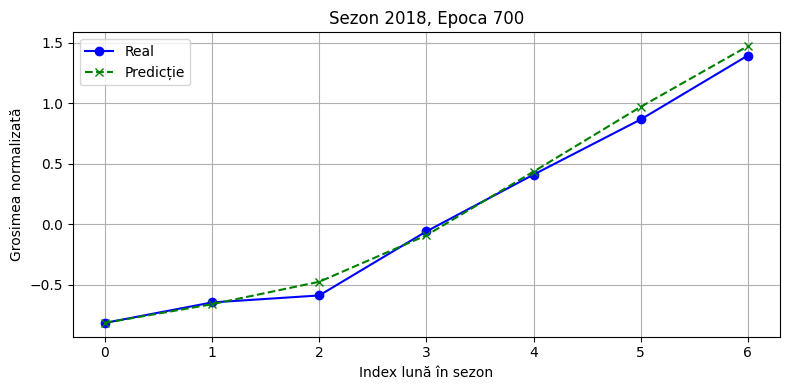

epoca 800: Loss = 0.002806


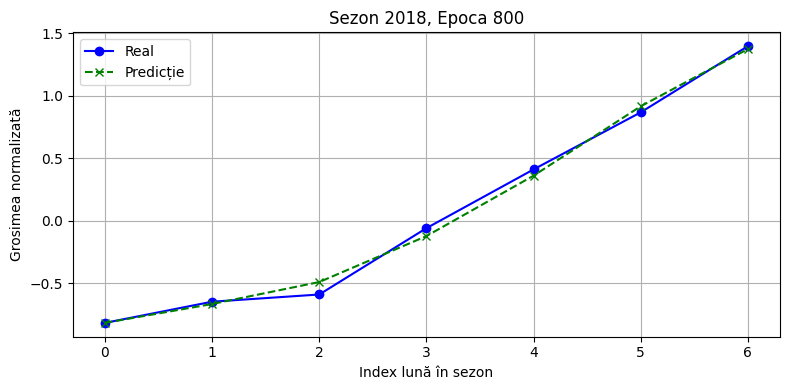

epoca 900: Loss = 0.005424


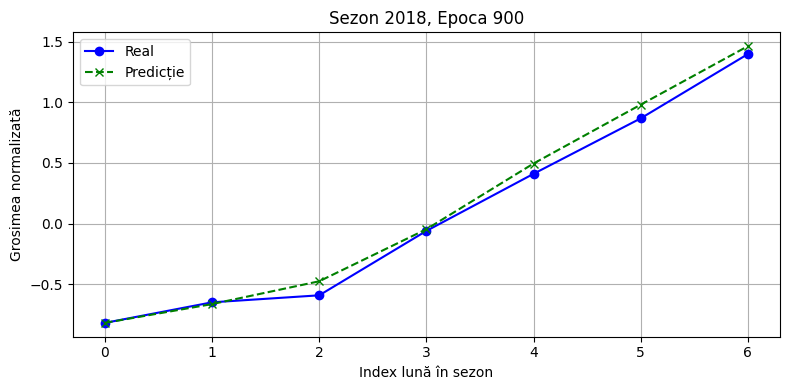

--- antrenare sezon 2019 ---
epoca 0: Loss = 0.522135


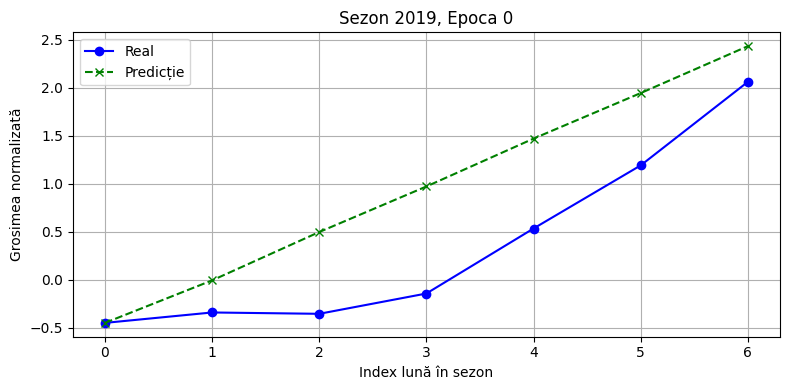

epoca 1: Loss = 0.223780


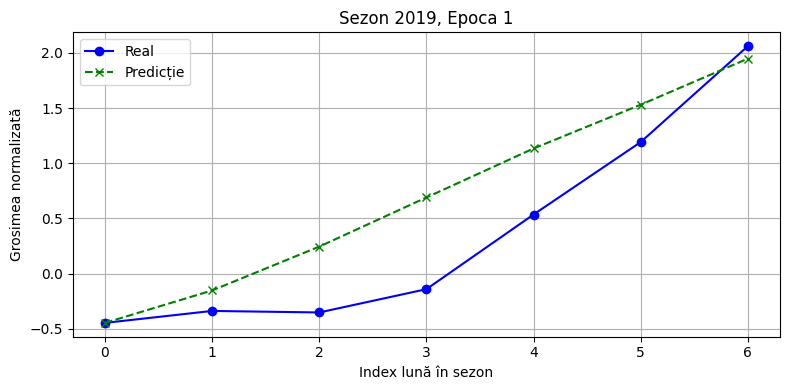

epoca 100: Loss = 0.013792


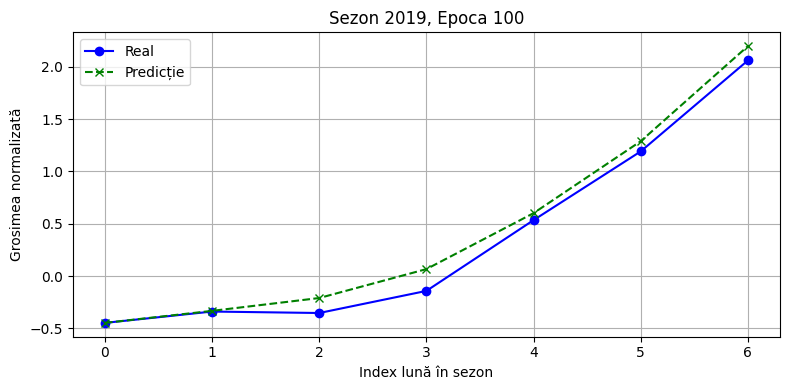

epoca 200: Loss = 0.007511


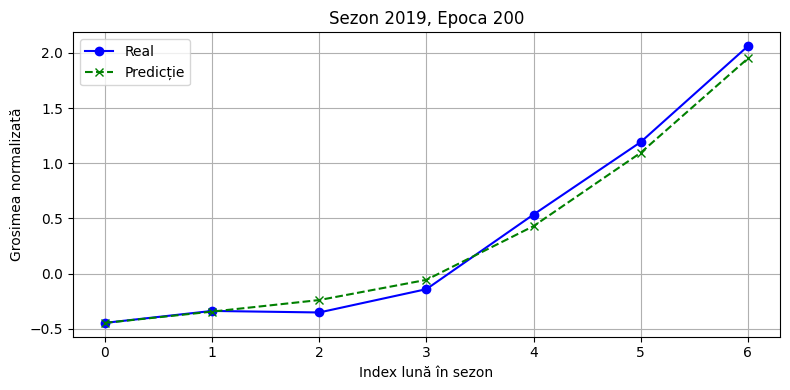

epoca 300: Loss = 0.011630


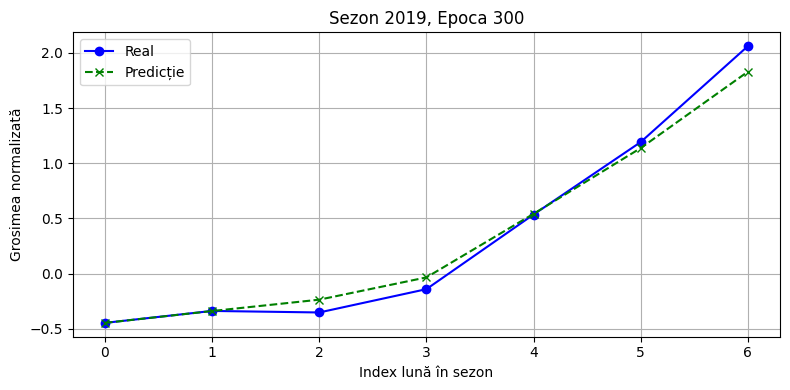

epoca 400: Loss = 0.003717


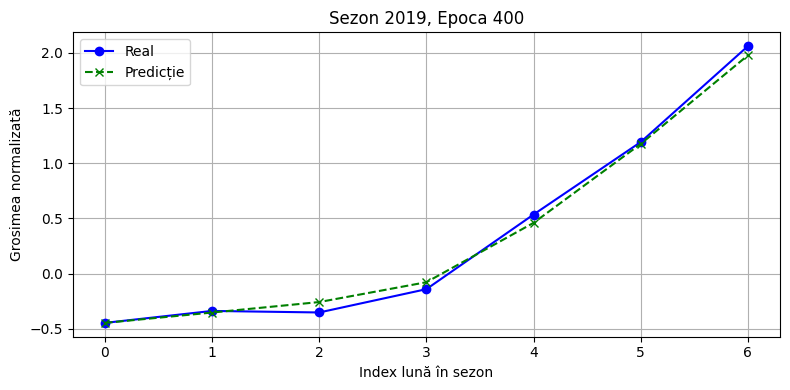

epoca 500: Loss = 0.005260


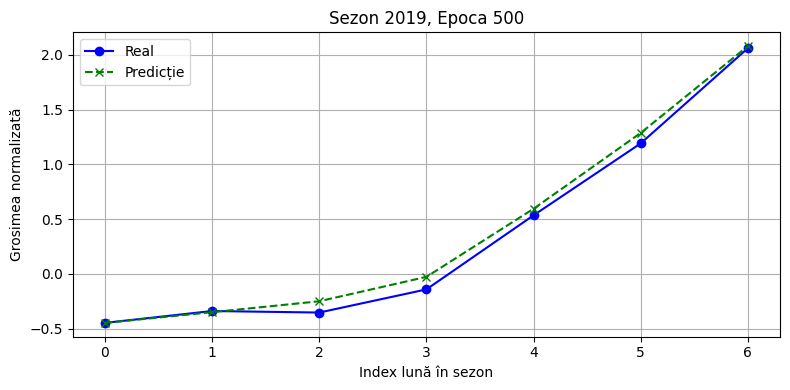

epoca 600: Loss = 0.008141


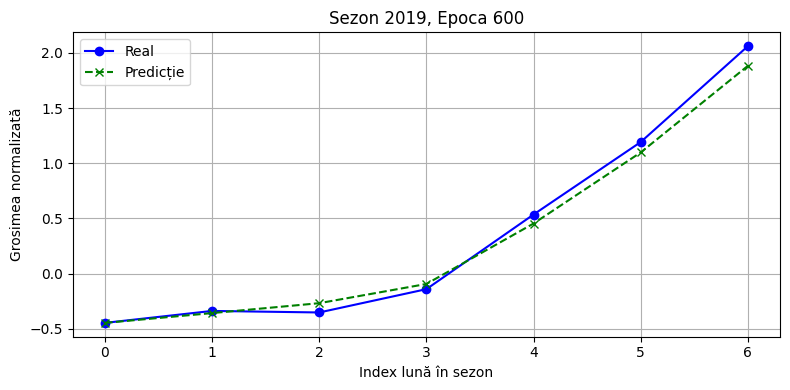

epoca 700: Loss = 0.003517


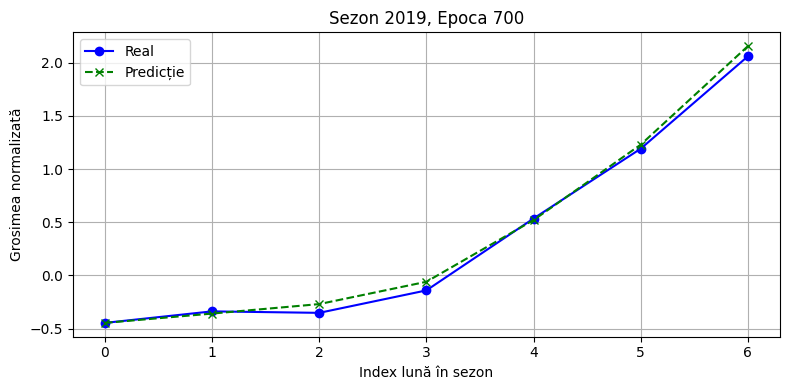

epoca 800: Loss = 0.002937


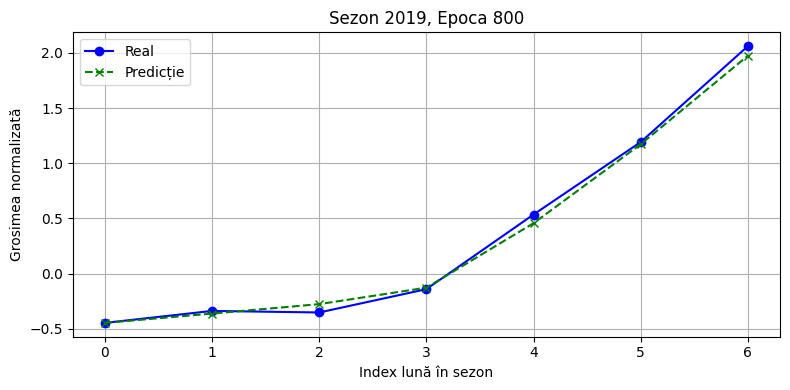

epoca 900: Loss = 0.007644


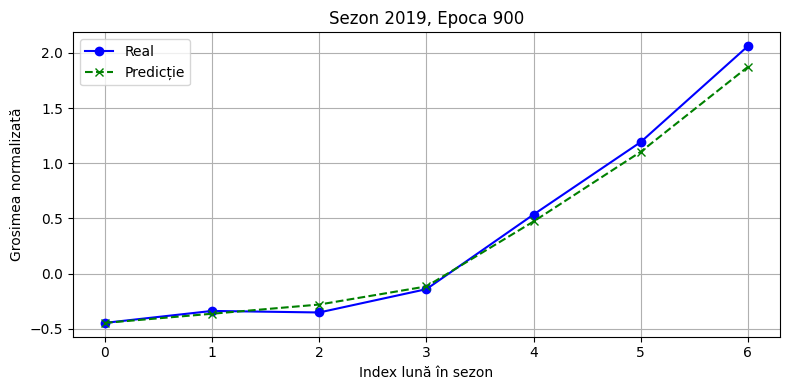

--- antrenare sezon 2020 ---
epoca 0: Loss = 0.862979


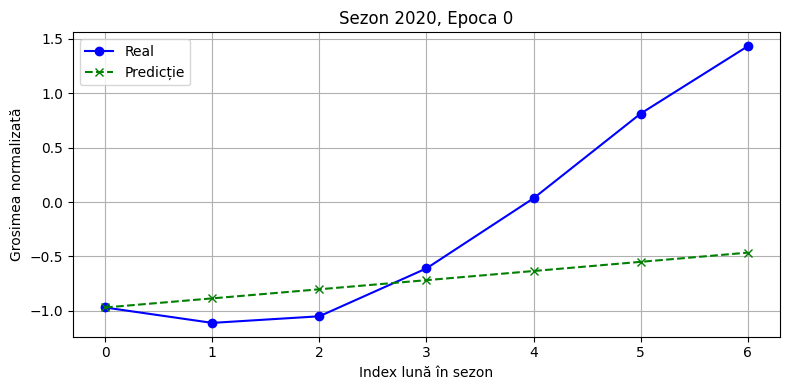

epoca 1: Loss = 0.798486


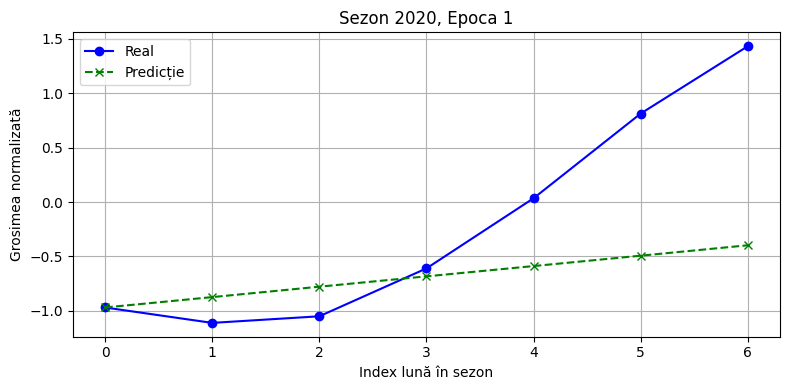

epoca 100: Loss = 0.038034


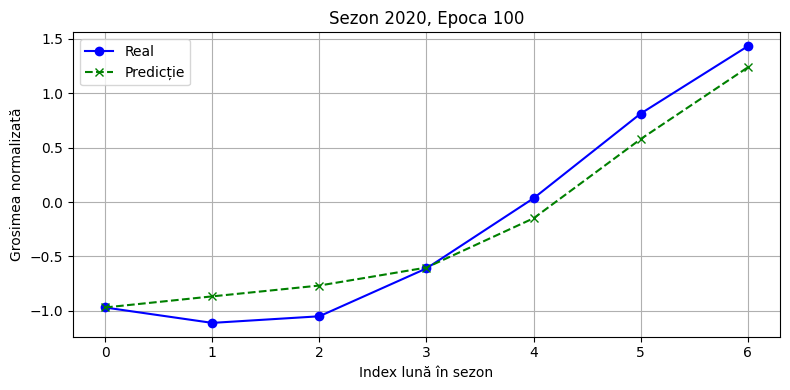

epoca 200: Loss = 0.055647


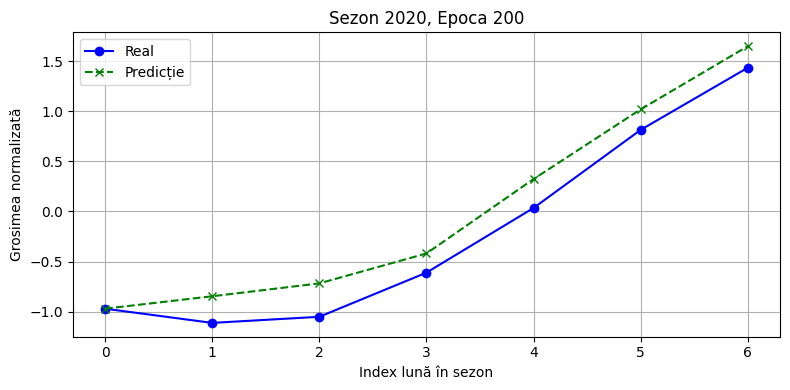

epoca 300: Loss = 0.029000


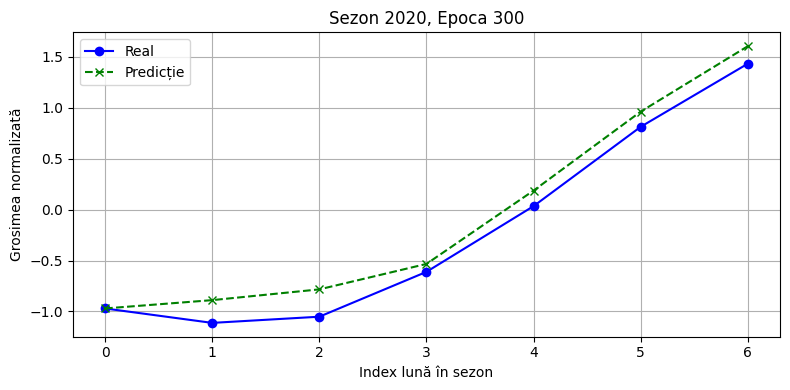

epoca 400: Loss = 0.016852


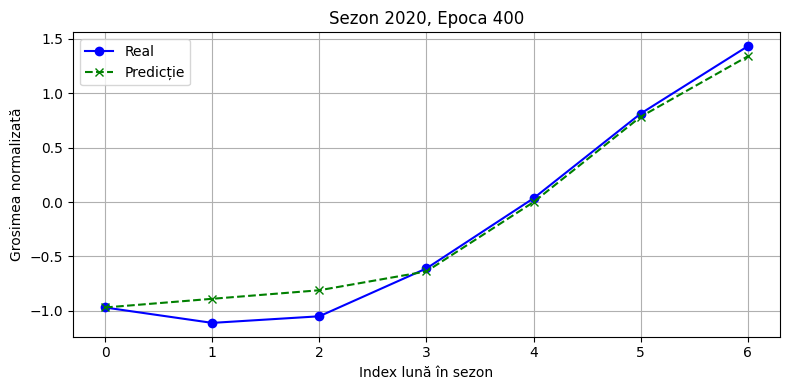

epoca 500: Loss = 0.016389


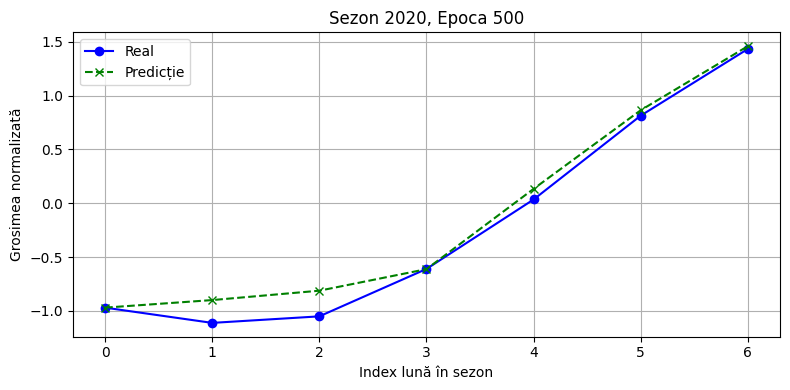

epoca 600: Loss = 0.027673


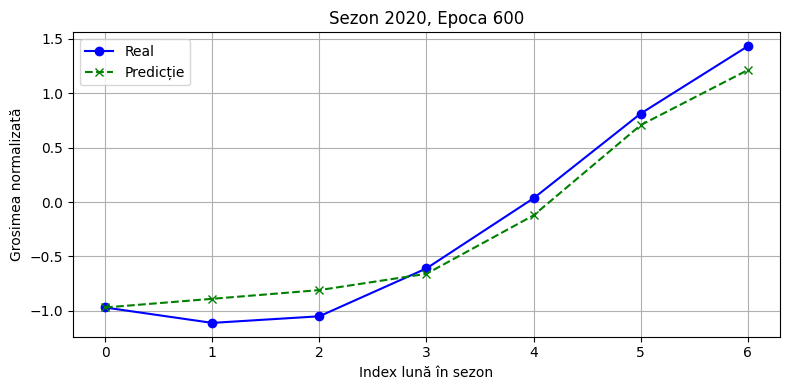

epoca 700: Loss = 0.015199


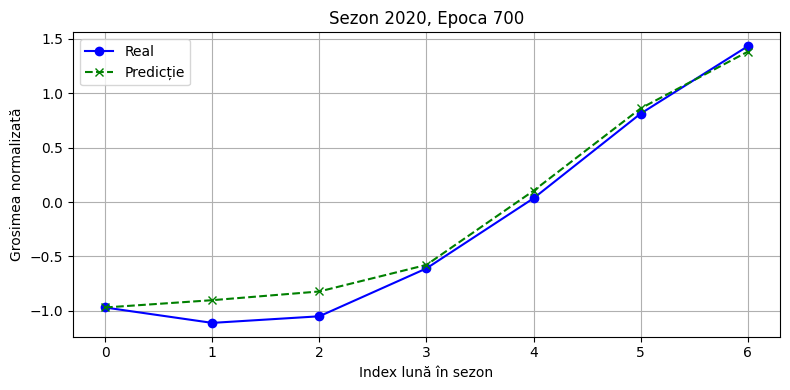

epoca 800: Loss = 0.023419


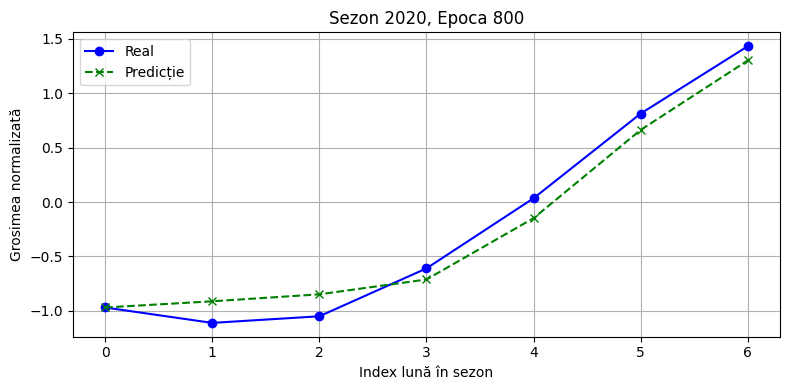

epoca 900: Loss = 0.026196


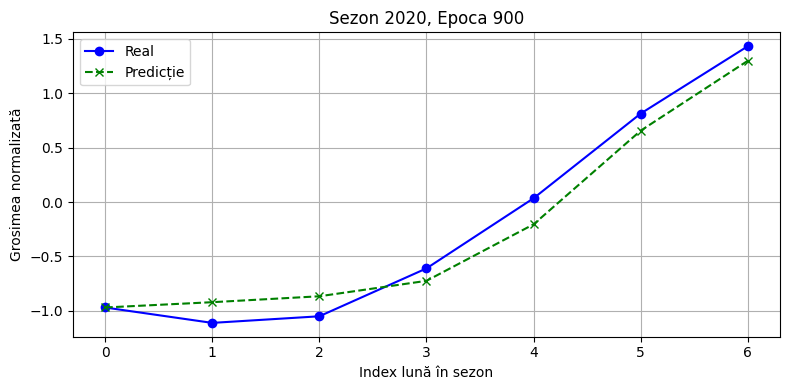

--- antrenare sezon 2021 ---
epoca 0: Loss = 1.027523


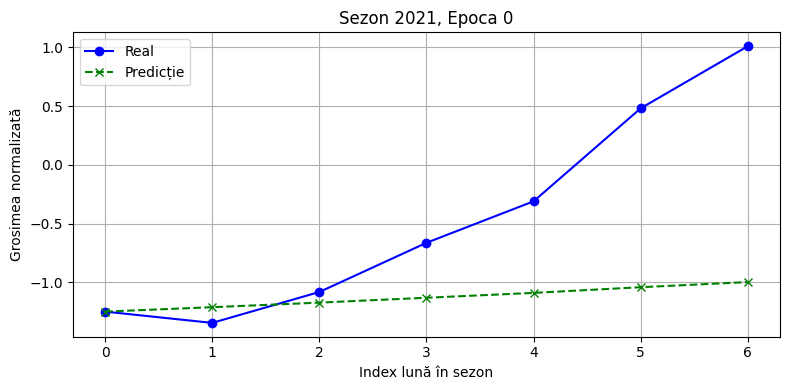

epoca 1: Loss = 0.964267


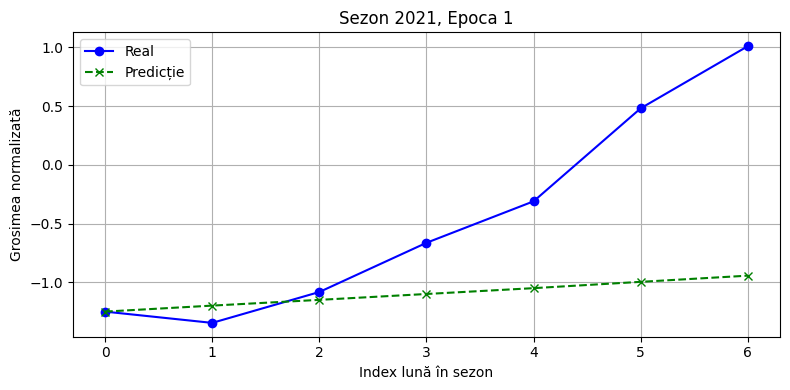

epoca 100: Loss = 0.047968


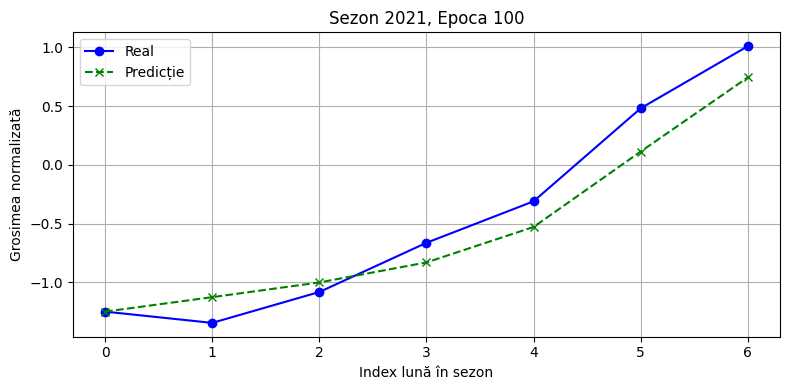

epoca 200: Loss = 0.010382


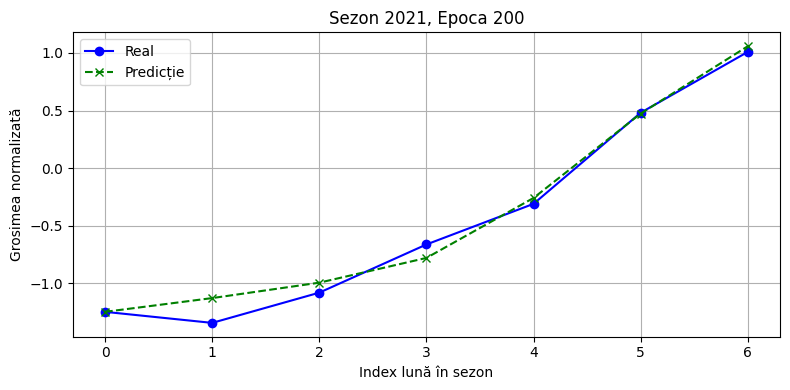

epoca 300: Loss = 0.016654


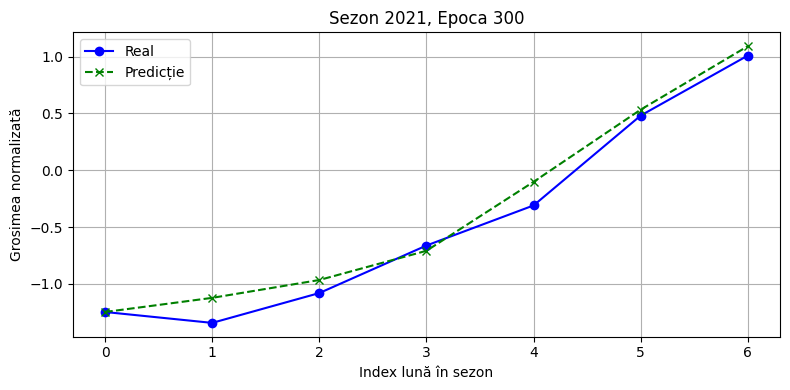

epoca 400: Loss = 0.021448


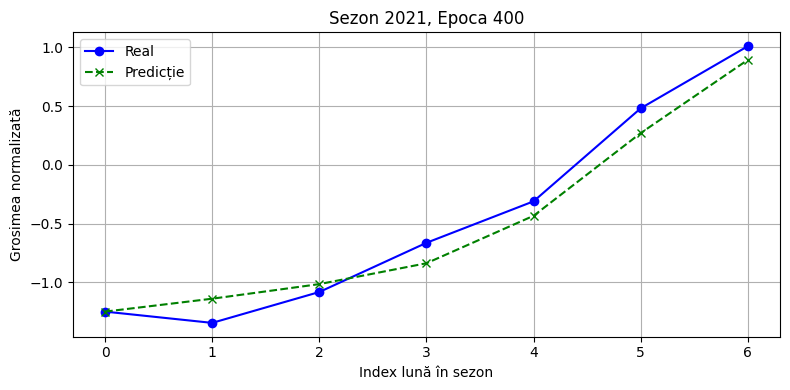

epoca 500: Loss = 0.009523


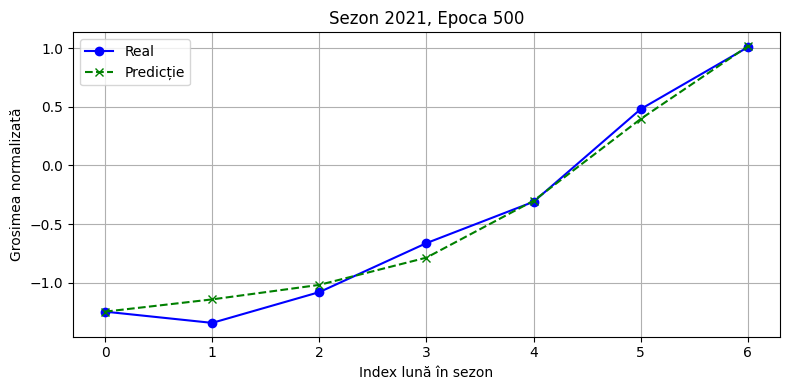

epoca 600: Loss = 0.024092


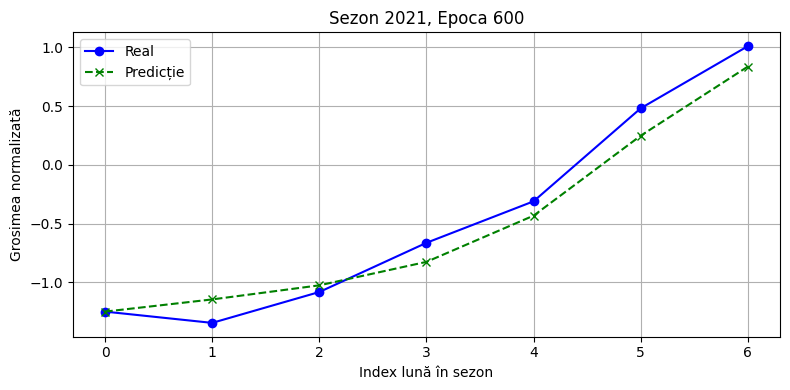

epoca 700: Loss = 0.009284


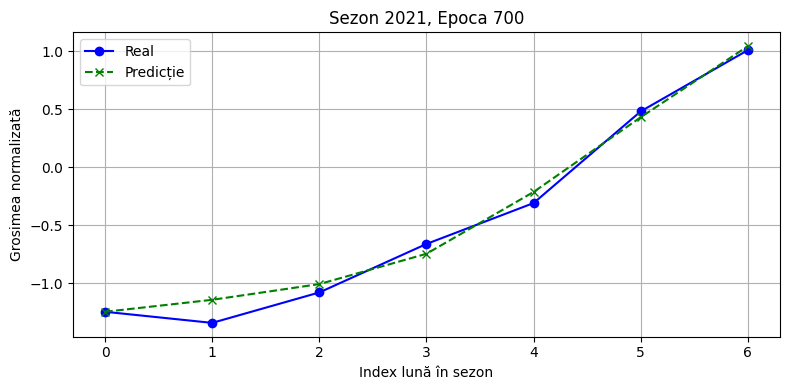

epoca 800: Loss = 0.011850


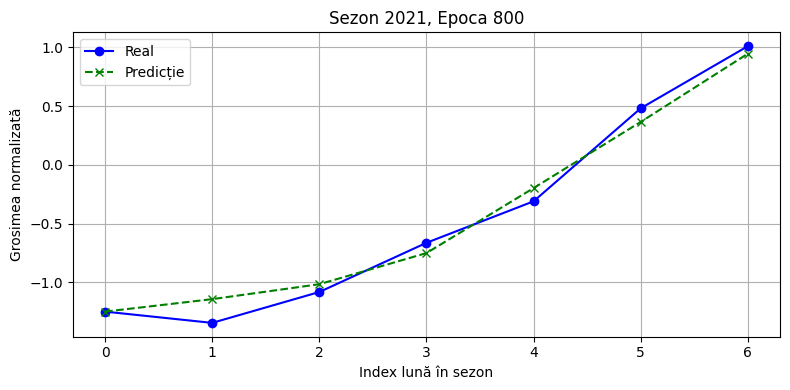

epoca 900: Loss = 0.009532


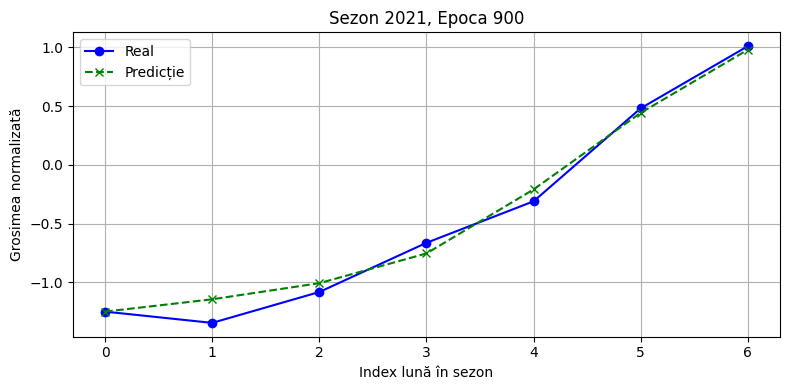

--- antrenare sezon 2022 ---
epoca 0: Loss = 0.544630


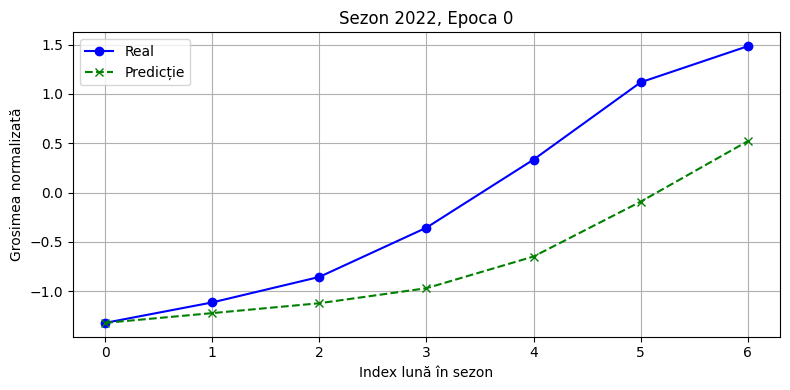

epoca 1: Loss = 0.014177


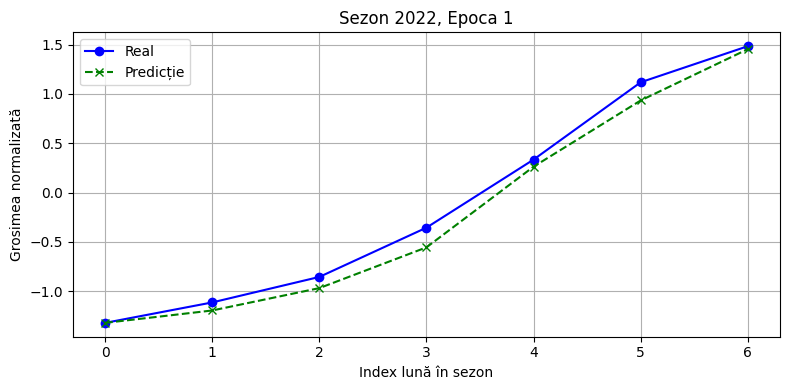

epoca 100: Loss = 0.027798


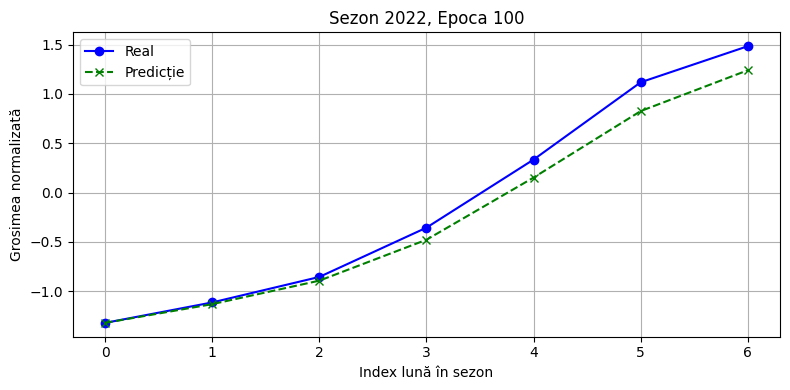

epoca 200: Loss = 0.009546


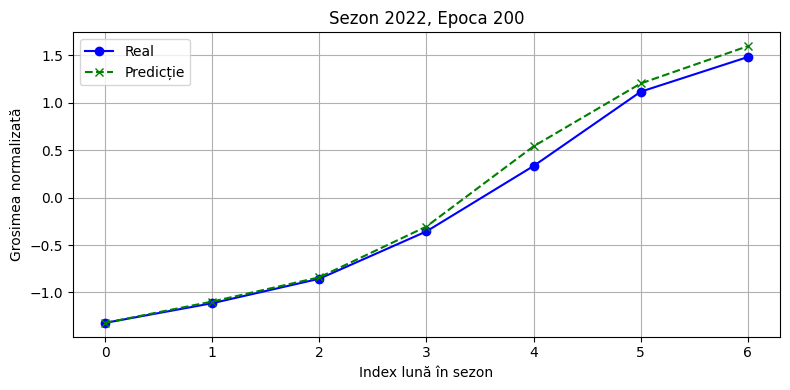

epoca 300: Loss = 0.008415


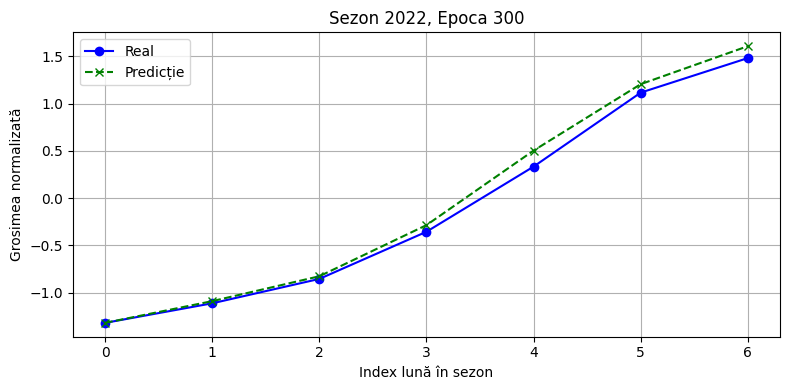

epoca 400: Loss = 0.003052


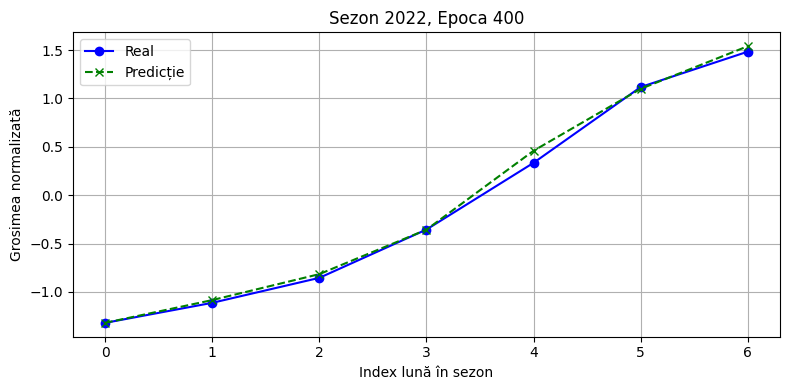

epoca 500: Loss = 0.000983


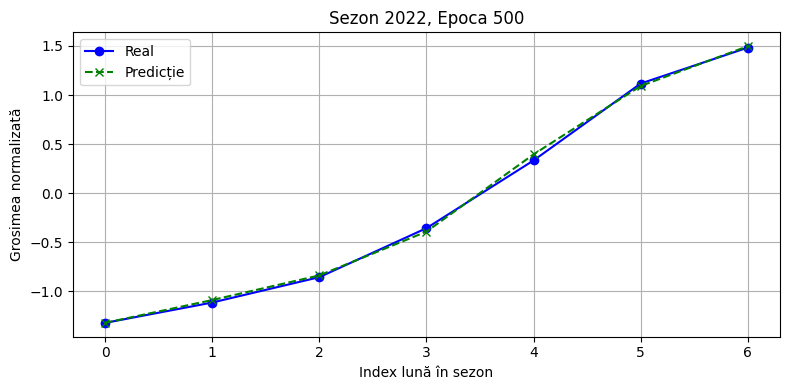

epoca 600: Loss = 0.001493


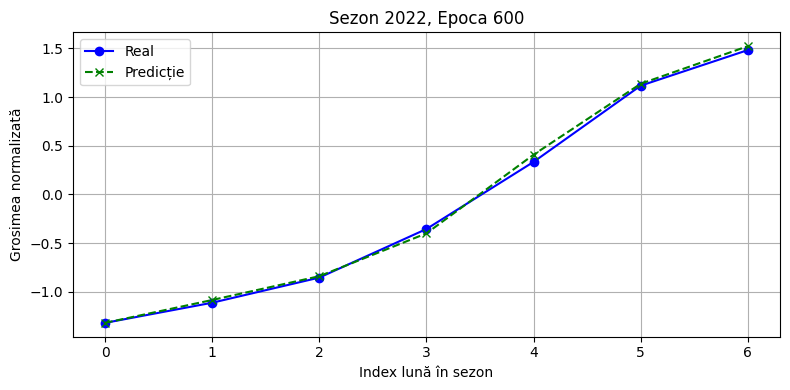

epoca 700: Loss = 0.002448


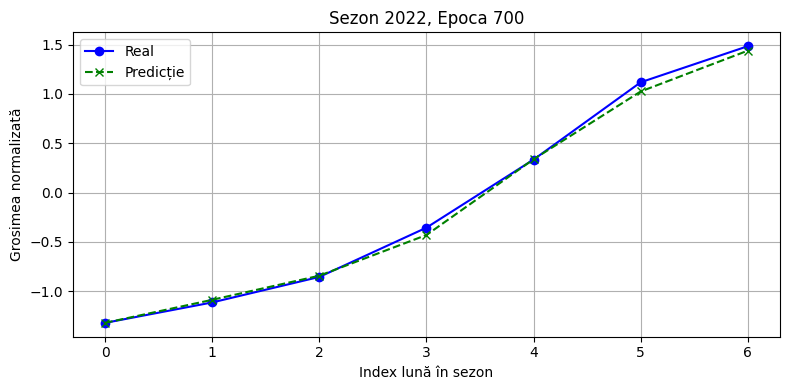

epoca 800: Loss = 0.002427


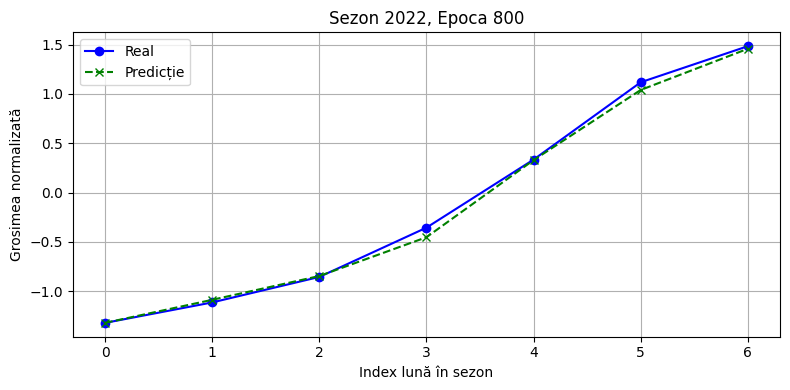

epoca 900: Loss = 0.001886


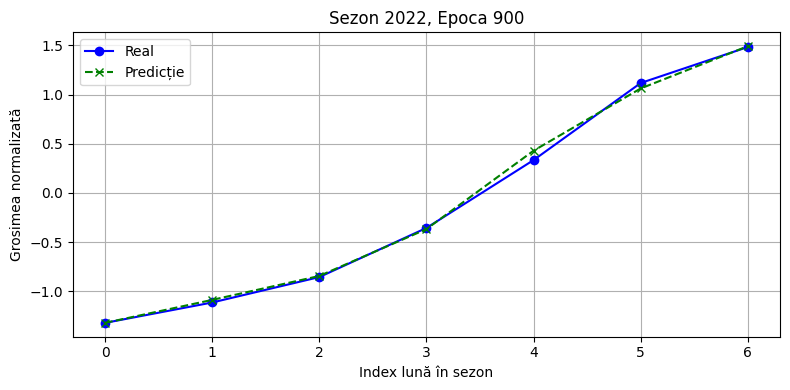

In [ ]:
train_df['time'] = pd.to_datetime(train_df['time'])

train_df['month'] = train_df['time'].dt.month
train_df['year'] = train_df['time'].dt.year

#ajustare season_year ca sa se termine primavara
train_df['season_year'] = train_df['year'] + (train_df['month'] >= 10).astype(int)
train_df = train_df[train_df['month'].isin([10,11,12,1,2,3,4])]

#grupare pe season_year
seasons = train_df.groupby('season_year')

#antrenare pe sezon
start_idx = 0
for season_id, (season_year, season_data) in enumerate(seasons, 1):
    n_rows = len(season_data)
    x_season = x_train_tensor[start_idx:start_idx+n_rows]
    start_idx += n_rows
    print(f'--- antrenare sezon {season_year} ---')
    train_season(x_season, func, sezon_id=season_year)

test

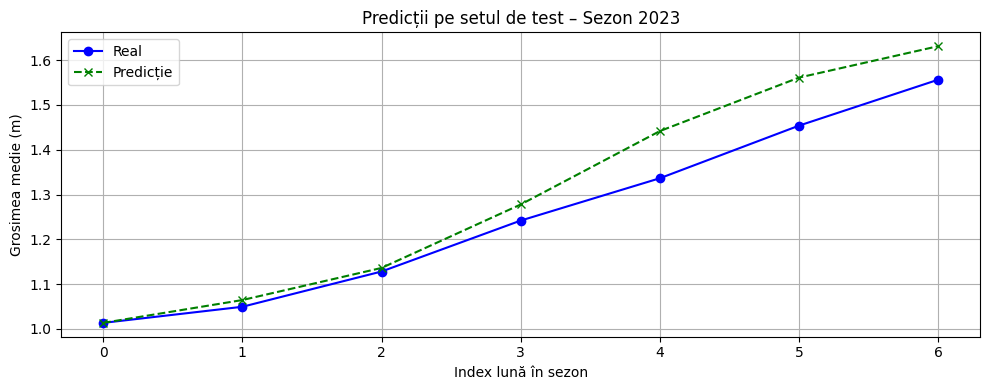

--- re-antrenare pe sezonul real 2023 ---
epoca 0: Loss = 0.090430


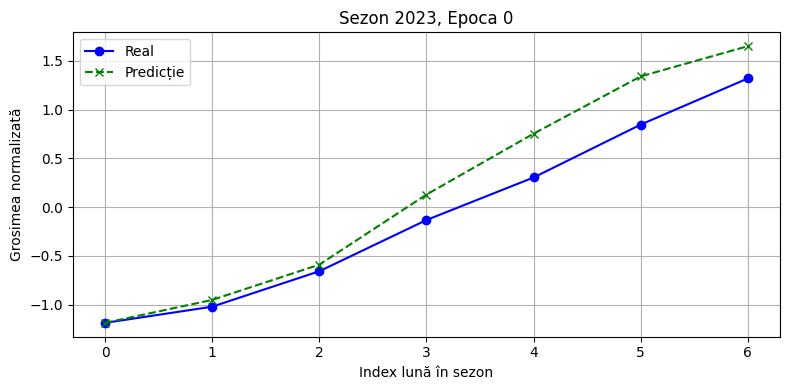

epoca 1: Loss = 0.019044


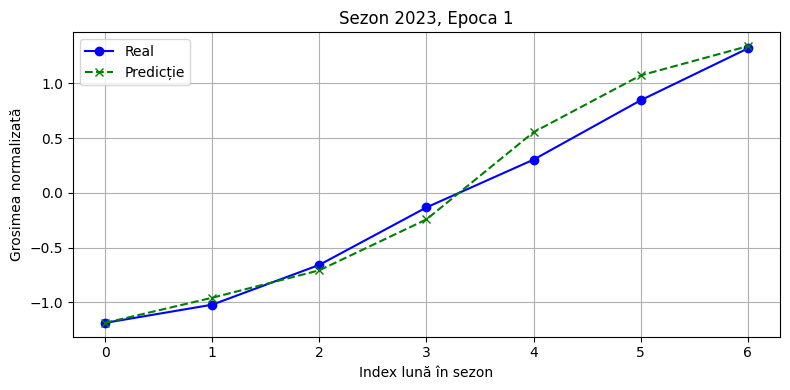

epoca 100: Loss = 0.015405


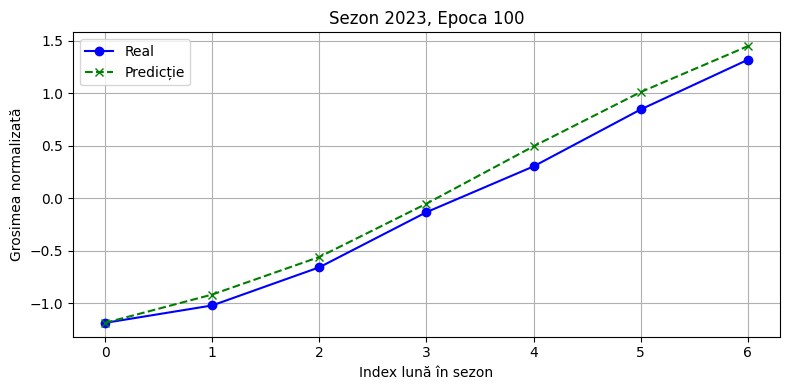

epoca 200: Loss = 0.008389


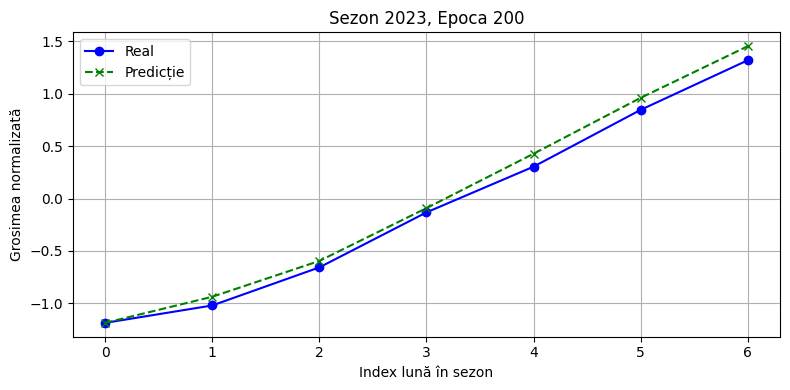

epoca 300: Loss = 0.002370


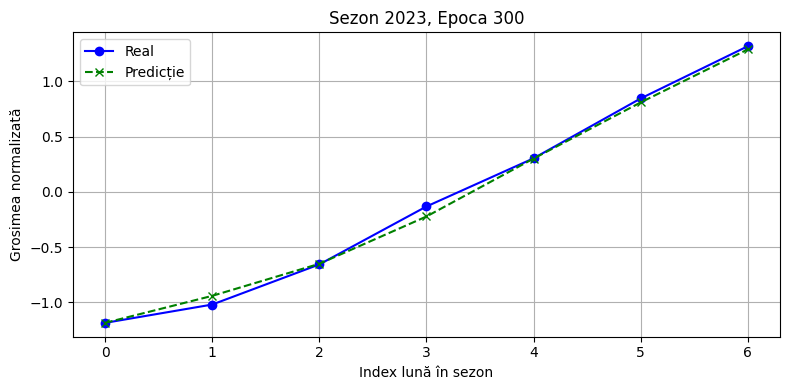

epoca 400: Loss = 0.002436


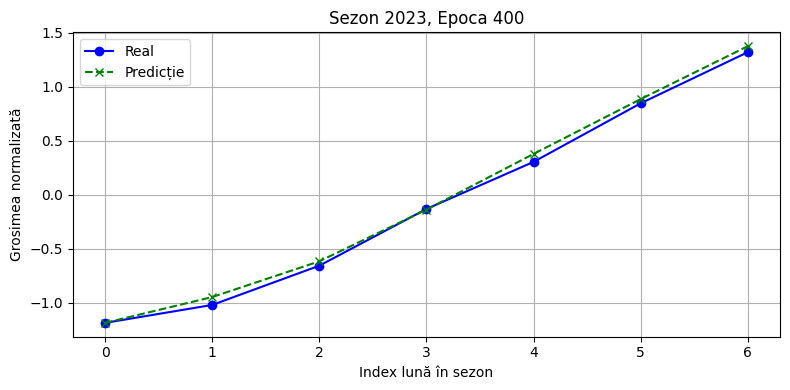

epoca 500: Loss = 0.002732


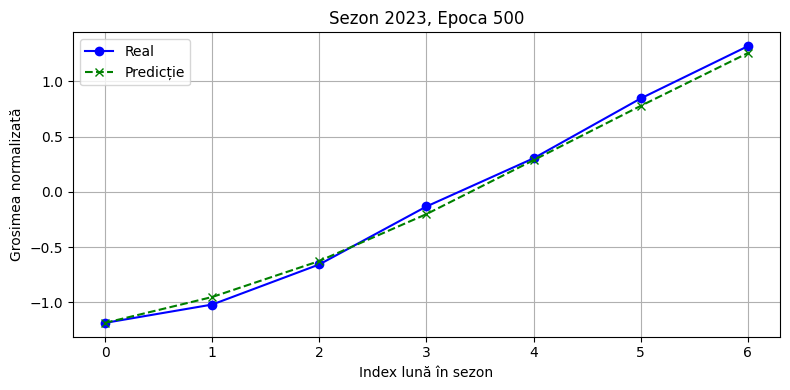

epoca 600: Loss = 0.001546


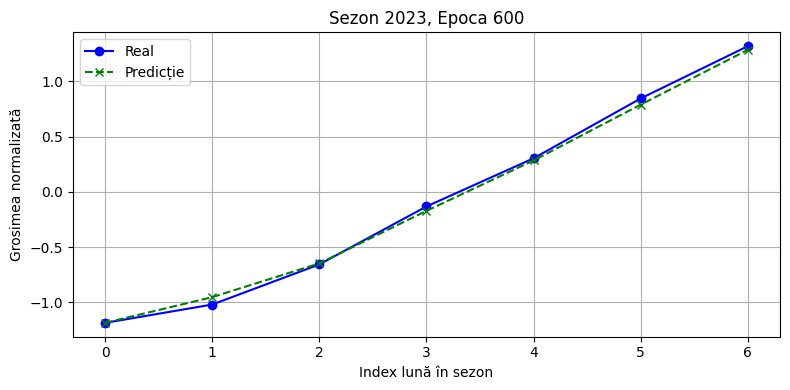

epoca 700: Loss = 0.005578


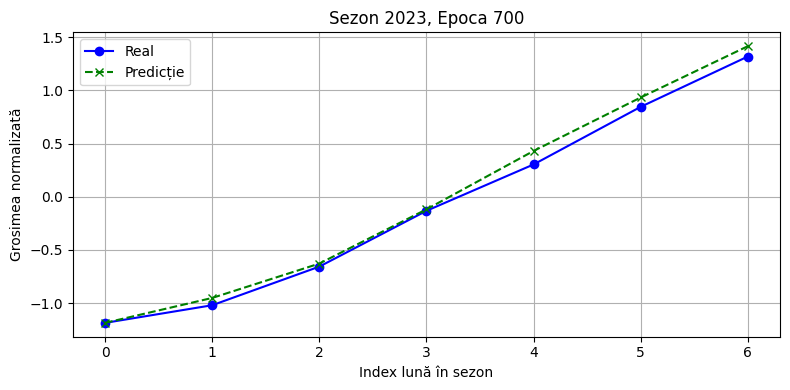

epoca 800: Loss = 0.001219


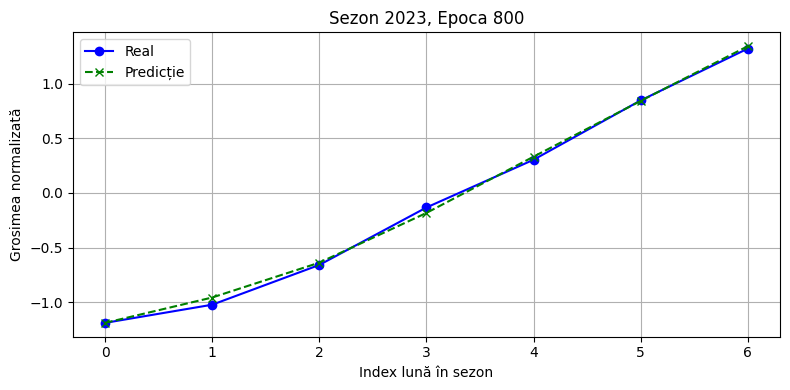

epoca 900: Loss = 0.001363


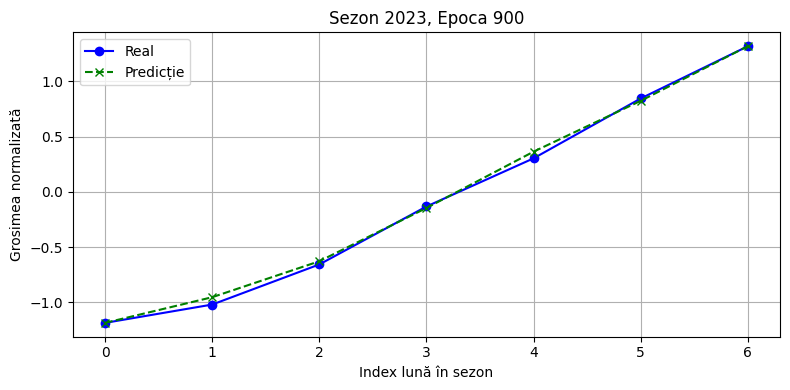

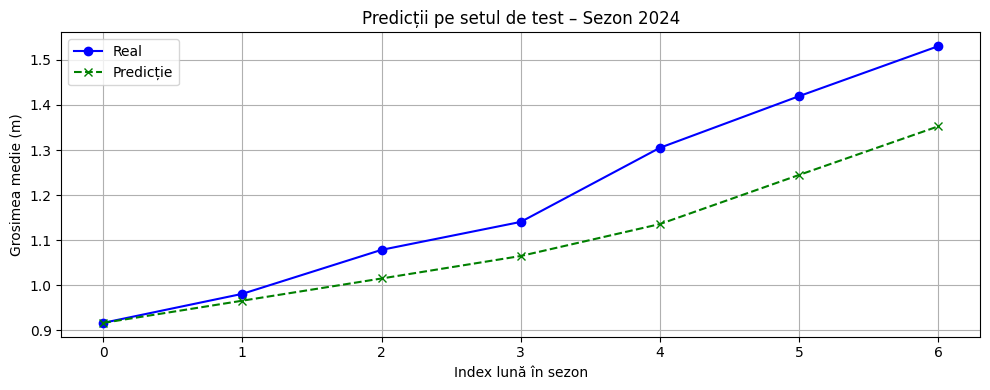

--- re-antrenare pe sezonul real 2024 ---
epoca 0: Loss = 0.331518


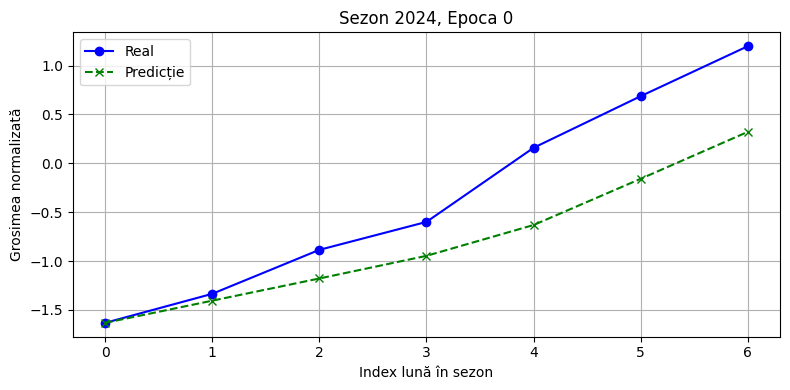

epoca 1: Loss = 0.133703


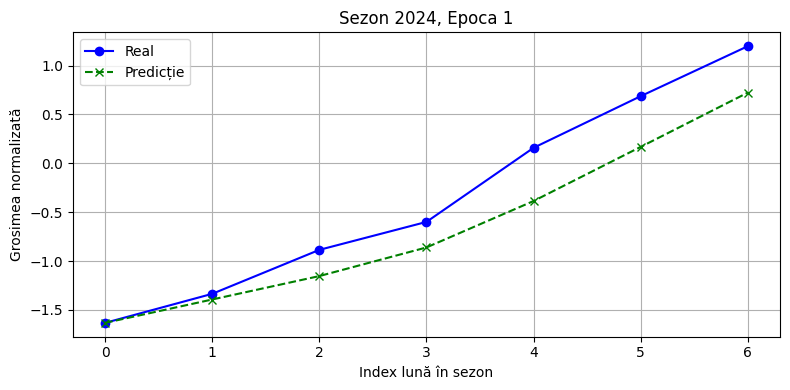

epoca 100: Loss = 0.003089


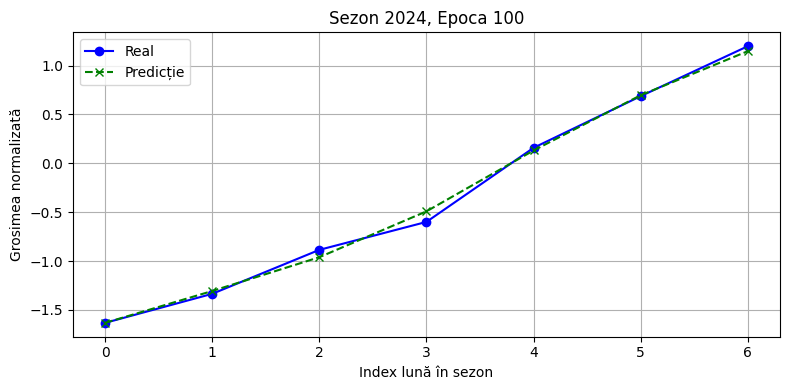

epoca 200: Loss = 0.002738


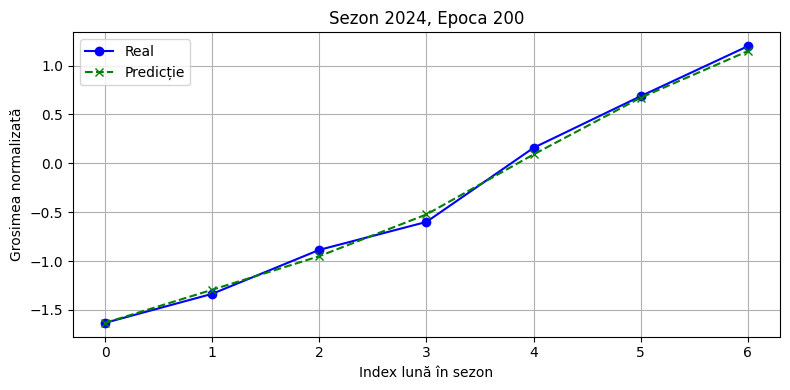

epoca 300: Loss = 0.001957


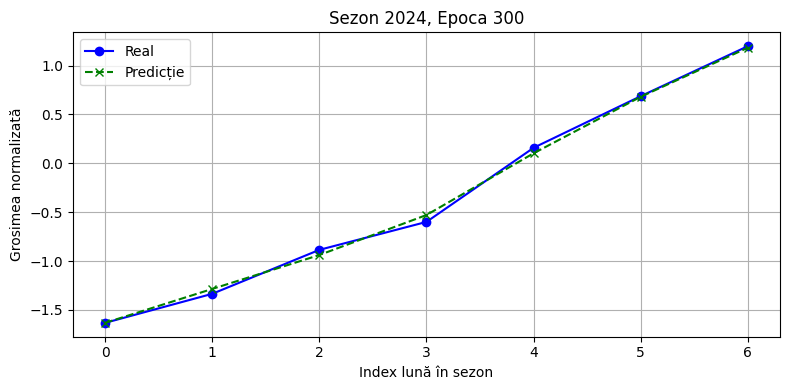

epoca 400: Loss = 0.001355


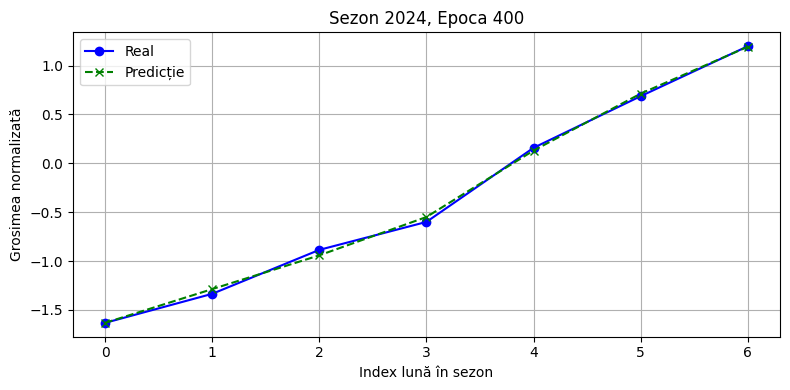

epoca 500: Loss = 0.003017


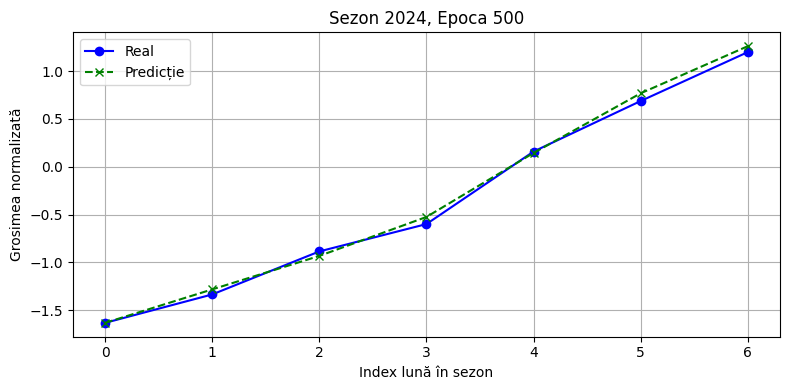

epoca 600: Loss = 0.001625


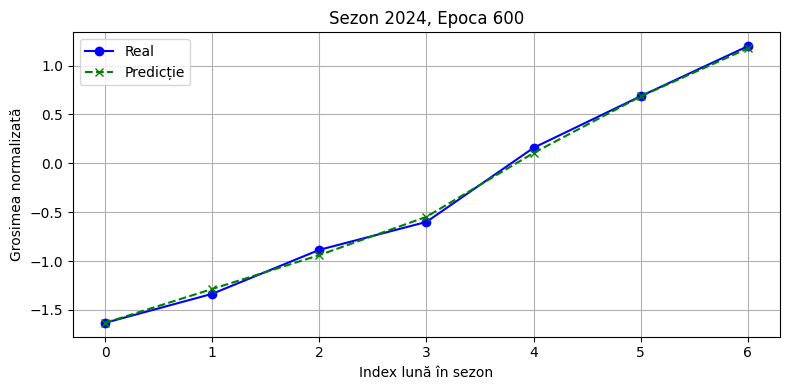

epoca 700: Loss = 0.001673


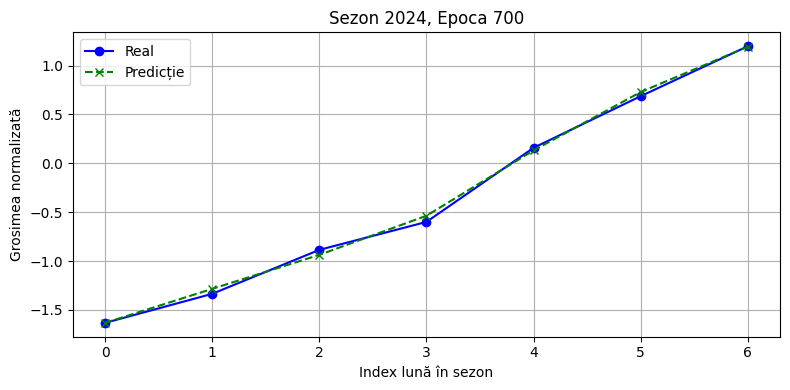

epoca 800: Loss = 0.001488


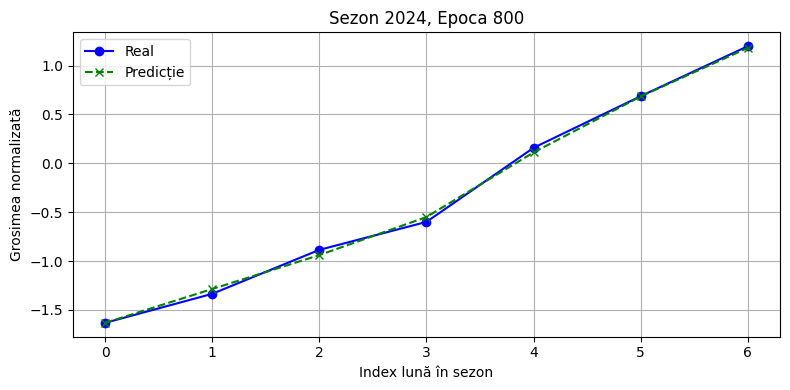

epoca 900: Loss = 0.002131


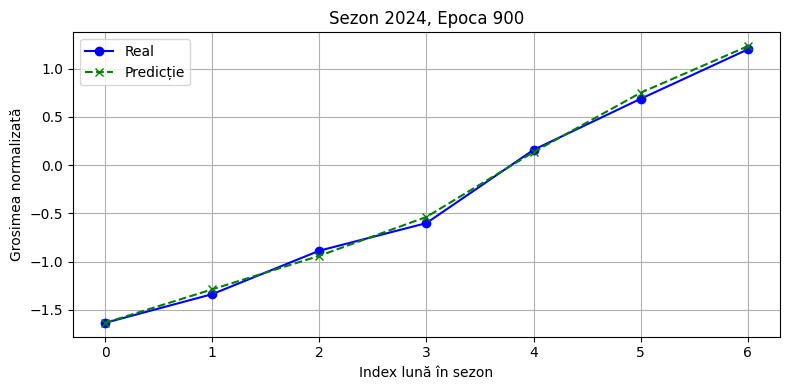

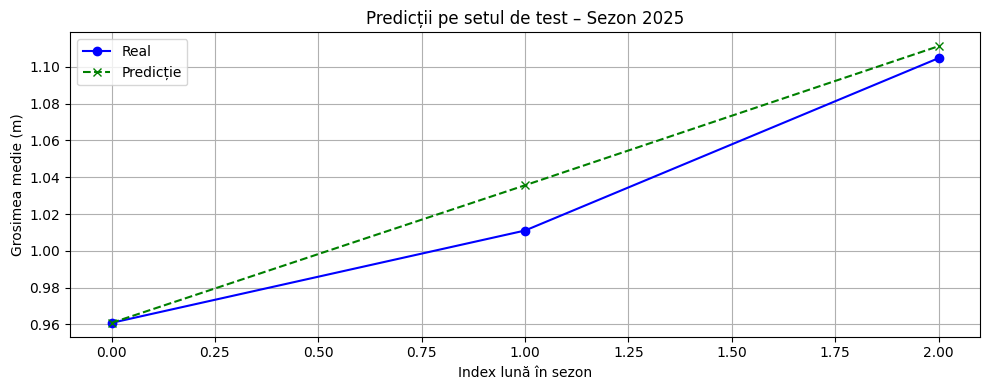

--- re-antrenare pe sezonul real 2025 ---
epoca 0: Loss = 0.004607


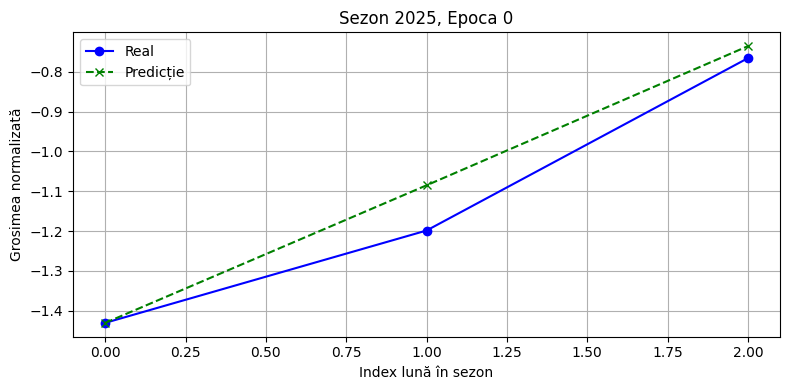

epoca 1: Loss = 0.003779


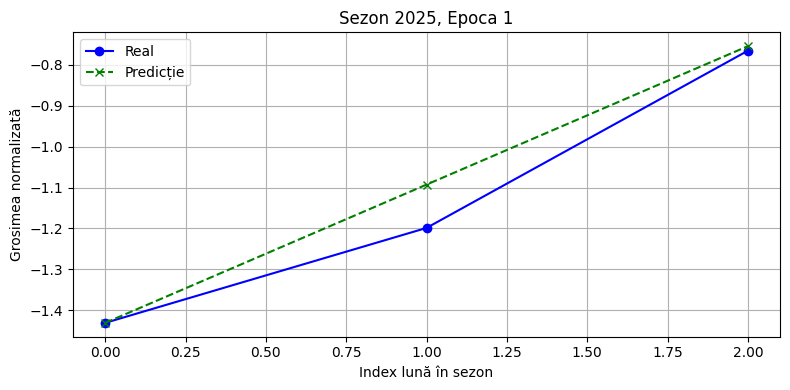

epoca 100: Loss = 0.000818


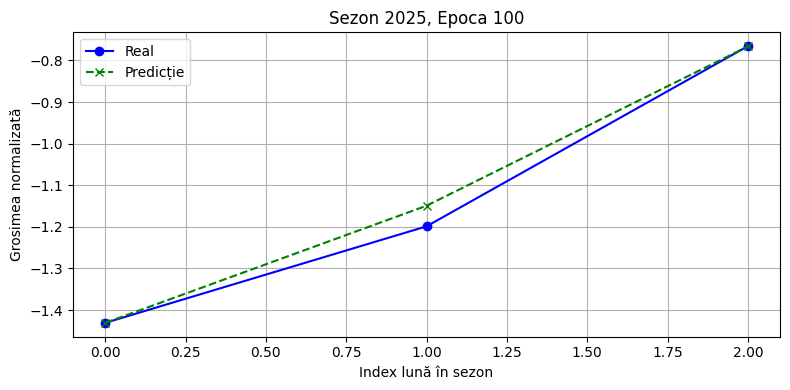

epoca 200: Loss = 0.000905


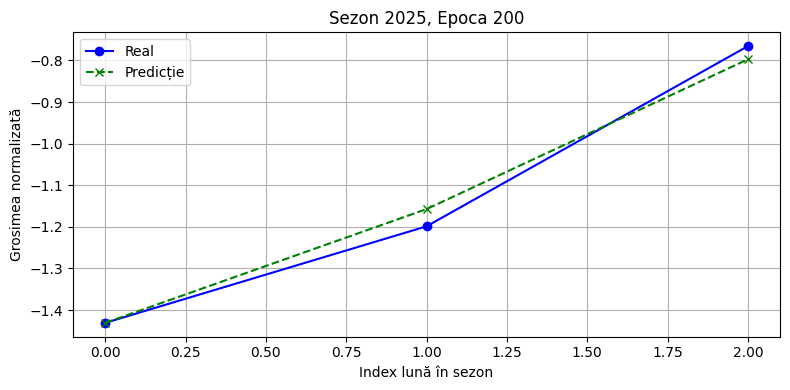

epoca 300: Loss = 0.000771


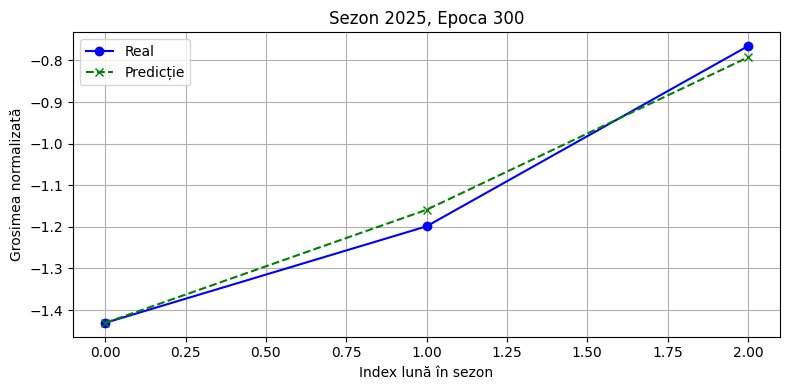

epoca 400: Loss = 0.000825


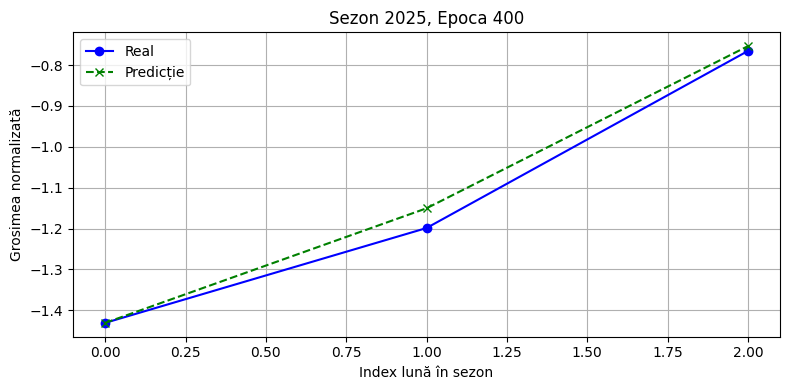

epoca 500: Loss = 0.000556


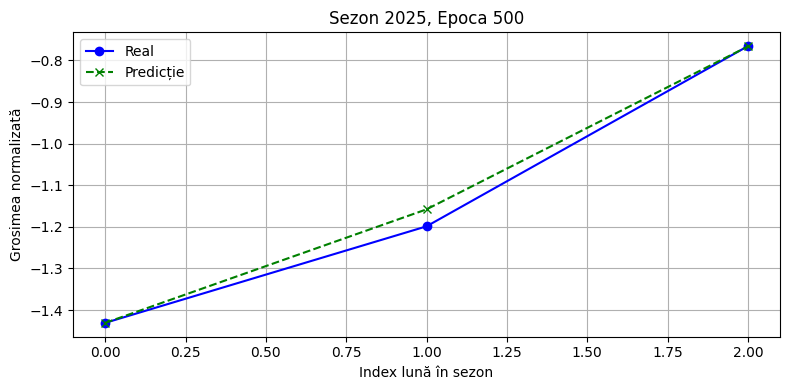

epoca 600: Loss = 0.000259


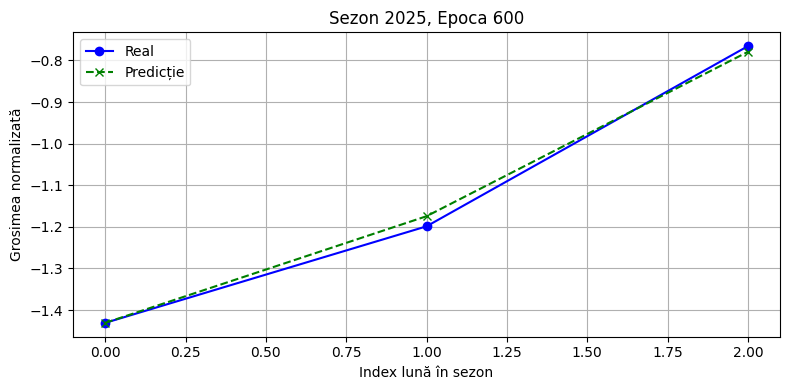

epoca 700: Loss = 0.000732


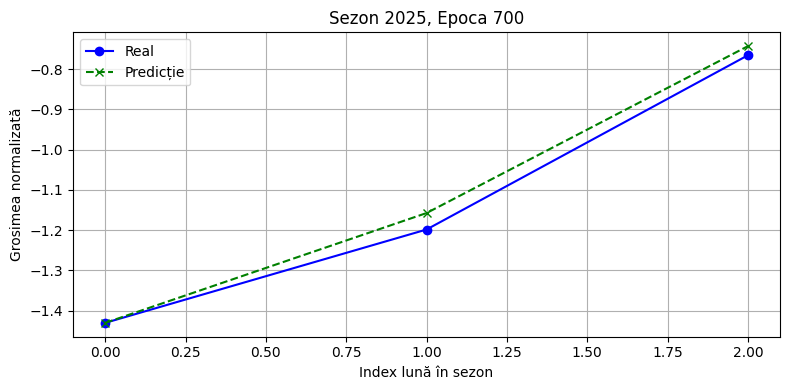

epoca 800: Loss = 0.001734


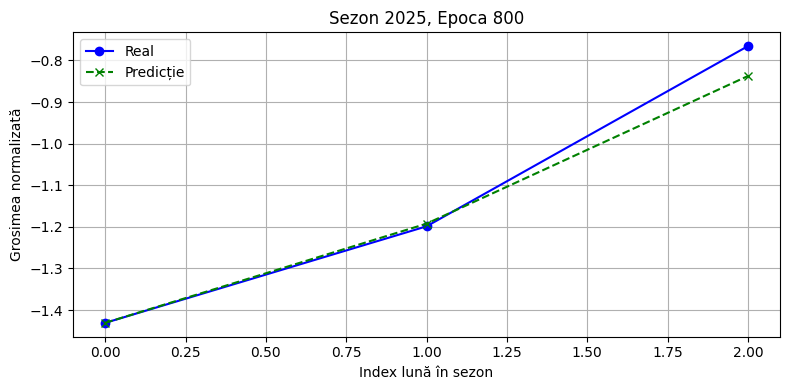

epoca 900: Loss = 0.000332


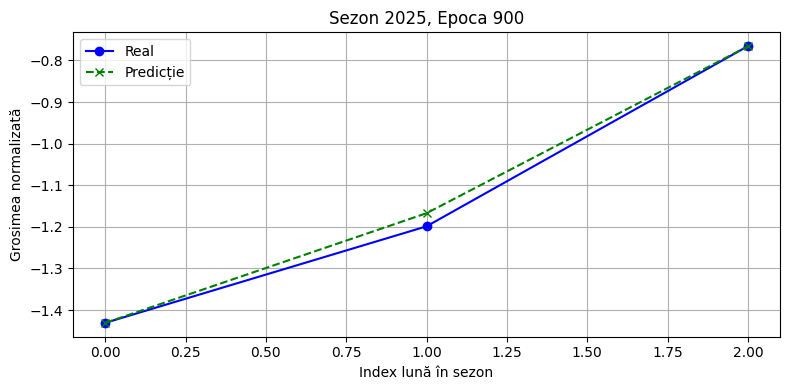

In [ ]:
#media si deviatia standard globala
mean_val, std_val = mean_train, std_train
test_seasons = test_df.groupby('season_year')

start_idx = 0
for sezon_id, (season_year, season_data) in enumerate(test_seasons, 1):
    n_rows = len(season_data)
    x_season = x_test_tensor[start_idx:start_idx + n_rows]
    start_idx += n_rows
    x0_season = x_season[0]
    t_season = torch.linspace(0, len(x_season)-1, len(x_season)).to(device)

    with torch.no_grad():
        pred_season = predict(x0_season, t_season, func)

    #denormalizare predictie
    pred_season_np = pred_season.cpu().numpy().squeeze() * std_val + mean_val
    real_season_np = season_data['ice_thickness'].values

    plt.figure(figsize=(10, 4))
    plt.plot(range(len(real_season_np)), real_season_np, label='Real', color='blue', marker='o')
    plt.plot(range(len(pred_season_np)), pred_season_np, label='Predicție', color='green', linestyle='--', marker='x')
    plt.xlabel('Index lună în sezon')
    plt.ylabel('Grosimea medie (m)')
    plt.title(f'Predicții pe setul de test – Sezon {season_year}')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    #reantrenare model
    print(f'--- re-antrenare pe sezonul real {season_year} ---')
    train_season(x_season, func, sezon_id=season_year)
